In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.stats import skewtest
import matplotlib.patches as patches
import scipy.stats as stats

In [2]:
data_dir = '/Users/tessarusch/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/external_selfResp_combined'
fig_dir = os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/figures')
table_dir =  os.path.expanduser('~/Library/CloudStorage/Box-Box/COVID-19 Adolphs Lab/core_analysis/tables')

In [3]:
selfResp_data = pd.read_csv(os.path.join(data_dir, 'CVD_core_summary_scores.csv'))
extMeas_data = pd.read_csv(os.path.join(data_dir, 'externalKeyMeasures_county.csv'))

In [4]:
data = selfResp_data.merge(extMeas_data, on = ['PROLIFIC_PID', 'wave','week'])
data = data.loc[data.wave.isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]),:].reset_index(drop = True)

# column-value dicts

In [5]:
id_vars = ['week', 'wave', 'PROLIFIC_PID', 
           'ethnicity', 'race', 'polit_party','sex', 'agecats',  'education', 'age',      
           'state','county','loc_description','weekly_income_self_cat','weekly_income_self_med_num']
local_context_vars = ['cases_avg_per_100k','ueRate','restriction_sum']
personal_experience = ['mean_social_network_health','weekly_income_self_cat_num',
                       'safety_measures']
attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']

idx_cols = id_vars
value_cols = local_context_vars+personal_experience




value_cols = local_context_vars + personal_experience
data = data[id_vars+local_context_vars+personal_experience+attitude_vars]

# colapse sex var
data.loc[data.sex == 'Female, Female','sex'] = 'Female'
data.loc[data.sex == 'CONSENT REVOKED','sex'] = 'Prefer not to say'

# order demographic varianles var
incomecat_numeric_dict = {'<$250': 1, '$250 - $499':2, '$500 - $999':3,'$1000 -$1499':4,
                       '$1500 - $2999':5, '>$3000':6}
incomecat_cat_dict = {1:'<$250' ,2: '$250 - $499', 3:'$500 - $999',4:'$1000 -$1499',
                      5:  '$1500 - $2999', 6:'>$3000'}
data['incomecat_numeric'] = data['weekly_income_self_cat']
data['incomecat_numeric'] = data['weekly_income_self_cat'].replace(incomecat_numeric_dict)

education_dict = {1: 'some high school', 2: 'high school',
                  3: 'some college', 4: "Associate's degree", 
                  5: "Bachelor's degree", 6: 'some graduate education',
                  7: "Master's degree", 8: 'PhD', 
                  9: "Professional degree", 10: 'other'}
data['education_numeric'] = data['education']
data['education_numeric'] = data['education_numeric'].replace(education_dict)


location_dict = {'countryside_remote': 0, 'countryside_near_town': 1,
               'suburb_small_city': 2,'middle_small_city':3,
               'suburb_med_city': 4,'middle_med_city':5,
               'suburb_large_city':6,'middle_large_city_spread':7, 'middle_large_city_dense':8 }
location_dict_label = {0:'countryside\nremote', 1: 'countryside\nnear town',
                 2: 'suburb\nsmall city',3: 'middle\nsmall city',
                 4: 'suburb\nmed city',5: 'middle\nmed city',
                 6: 'suburb\nlargecity',7:'middle large city\nspread housing',8: 'middle large city\ndense housing'}
data['loc_numeric'] = data['loc_description']
data['loc_numeric'] = data['loc_description'].replace(location_dict)




# subject count per wave

In [6]:
# drop duplicates
data = data.drop_duplicates().reset_index(drop=True)


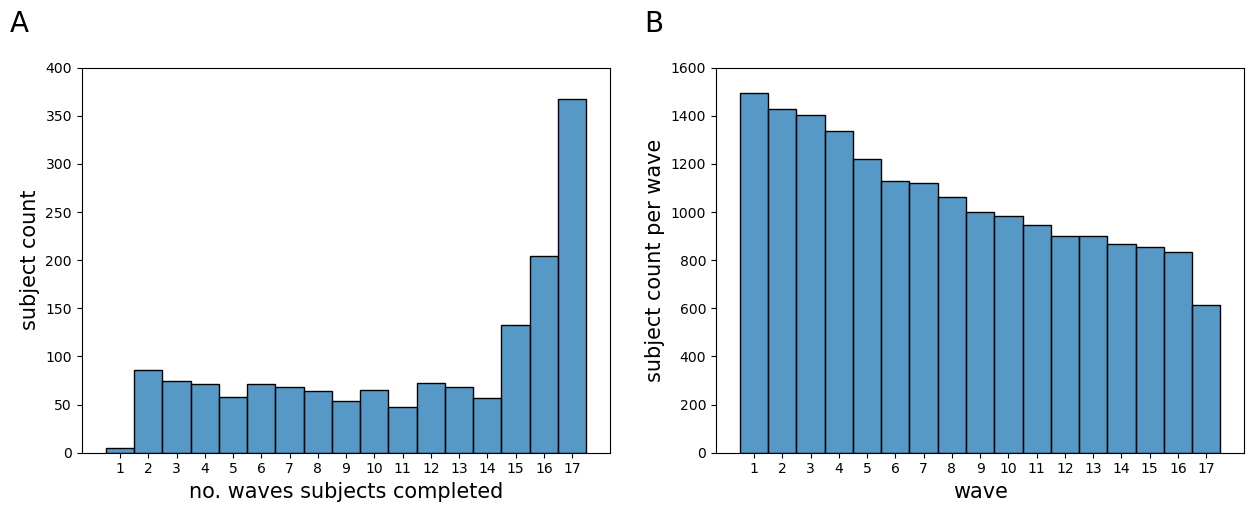

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

# number of waves completed
sns.histplot(data.PROLIFIC_PID.value_counts(),ax = ax[0], bins = 17, discrete = True)
ax[0].set_xlabel('no. waves subjects completed', fontsize = 15)
ax[0].set_ylabel('subject count', fontsize = 15)
ax[0].set_ylim(0,400)
ax[0].set_xticks(data.wave.unique());
ax[0].set()

# subject count per wave
sns.histplot(data, x = 'wave', ax = ax[1], bins = 17, discrete = True)
ax[1].set_xticks(data.wave.unique());
ax[1].set_xlabel('wave', fontsize = 15)
ax[1].set_ylabel('subject count per wave', fontsize = 15)
ax[1].set_ylim(0,1600)

# add panel label
for i, label in enumerate(['A', 'B']):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
               fontsize=20, va='top', ha='right')
    
img_format = 'png'
fig.savefig(os.path.join(fig_dir, 'subject_wave_counts.' + img_format), format=img_format)


# Drop Subjects with less than 10 waves

In [8]:
# drop subjects with less than 10 waves
pid_include = data.PROLIFIC_PID.value_counts().index[data.PROLIFIC_PID.value_counts()>9]
data = data.loc[data.PROLIFIC_PID.isin(pid_include)]


# z-score

In [9]:
#subject-level 
data[value_cols] = data[value_cols].apply(pd.to_numeric,axis=1) 
data_sub_zscore = data[idx_cols + attitude_vars+value_cols].copy()

for pid in data.PROLIFIC_PID.unique():
    tmp_pid_dat = data.loc[data.PROLIFIC_PID == pid, idx_cols + value_cols].copy()
    if len(tmp_pid_dat)>2:
        for val_col in value_cols:
            if tmp_pid_dat[val_col].std()!=0:
                tmp_pid_dat[val_col] =(tmp_pid_dat[val_col]-tmp_pid_dat[val_col].mean())/tmp_pid_dat[val_col].std()
            else:
                tmp_pid_dat[val_col] =(tmp_pid_dat[val_col]-tmp_pid_dat[val_col].mean())

        data_sub_zscore.loc[data_sub_zscore.PROLIFIC_PID == pid, idx_cols + value_cols]= tmp_pid_dat

        
        
#across subjects
data_zscore = data[idx_cols + attitude_vars +value_cols].copy()
data_zscore[value_cols] = (data[value_cols] - data[value_cols].mean())/data[value_cols].std()


# Demographics 

In [10]:
w3_data = data.loc[data.wave==3,:].copy()
w3_data.education = w3_data.education.replace(education_dict)

print('sex')
print(w3_data.sex.value_counts()/len(w3_data)*100)

print('\n age median')
print(w3_data.age.median())
print('age min')
print(w3_data.age.min())
print('age max')
print(w3_data.age.max())

print('\n polit affil')
print(w3_data.polit_party.value_counts()/len(w3_data)*100)

print('\n race')
print(w3_data.race.value_counts()/len(w3_data)*100)

print('\n ethnicity')
print(w3_data.ethnicity.value_counts()/len(w3_data)*100)

print('\n weekly income self')
print(w3_data.weekly_income_self_cat.value_counts()/len(w3_data)*100)

print('\n education')
print(w3_data.education.value_counts()/len(w3_data)*100)

sex
Female               50.403226
Male                 49.193548
Prefer not to say     0.403226
Name: sex, dtype: float64

 age median
39.0
age min
18.0
age max
77.0

 polit affil
Democrat       53.427419
Independent    28.931452
Republican     14.818548
Other           2.822581
Name: polit_party, dtype: float64

 race
White                                        77.016129
Asian                                         9.778226
Black or African American                     7.056452
Multiracial                                   3.830645
Other                                         1.411290
Prefer not to disclose                        0.504032
American Indian/Alaska Native                 0.302419
Native Hawaiian or Other Pacific Islander     0.100806
Name: race, dtype: float64

 ethnicity
Not Hispanic or Latino     90.423387
Hispanic or Latino          8.971774
 Prefer not to disclose     0.604839
Name: ethnicity, dtype: float64

 weekly income self
<$250            41.431452
$250 - $

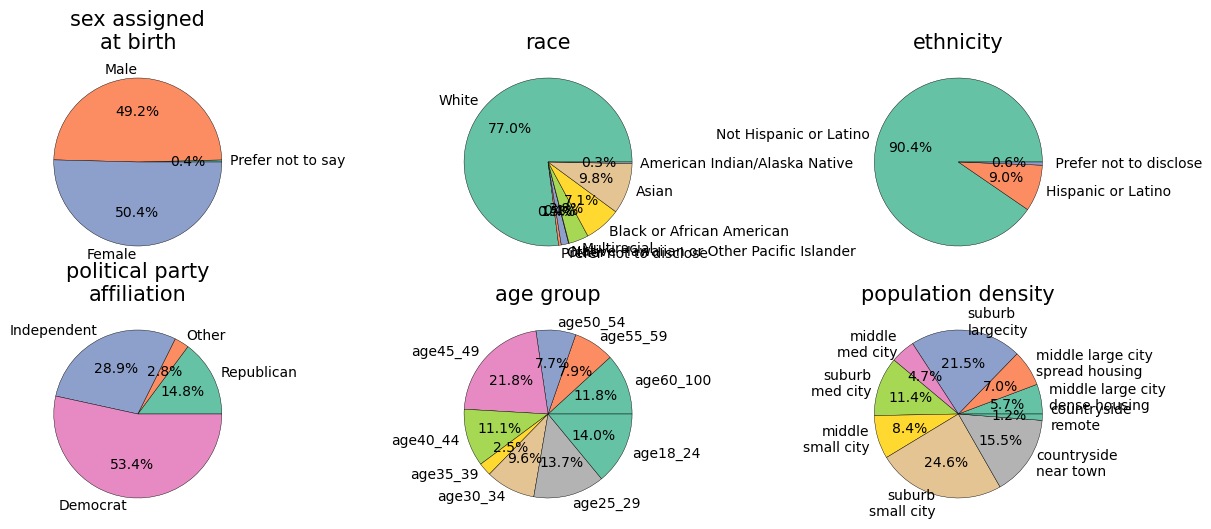

In [11]:
# Demographic pie charts

titles = ['sex assigned\nat birth', 'race', 'ethnicity',
          'political party\naffiliation', 'age group', 'population density']

fig, ax = plt.subplots(2,3, figsize = (15,6))
for idx, dem_var in enumerate(['sex', 'race', 'ethnicity',
                               'polit_party','agecats', 'loc_numeric']):
    row = 0
    if idx>2:
        row = 1
    col = idx%3
    
    data = data.sort_values(by=[dem_var])
    
    labels = data.loc[data.wave ==3,dem_var].value_counts().sort_index(ascending=False).index
    # semanitc labels
    if dem_var == 'education':
        labels = pd.Series(labels).replace(education_dict).values
    if dem_var == 'incomecat_numeric':
        labels = pd.Series(labels).replace(incomecat_cat_dict).values
    if dem_var == 'incomecat_numeric':
        labels = pd.Series(labels).replace(incomecat_cat_dict).values
    if dem_var == 'loc_numeric':
        labels = pd.Series(labels).replace(location_dict_label).values
    
        

        
    values = data.loc[data.wave ==3,dem_var].value_counts().sort_index(ascending=False)
    ax[row,col].pie(values,
                autopct='%1.1f%%',
                labels=labels,
                colors=sns.color_palette('Set2'),
                wedgeprops={"edgecolor":"k",'linewidth': 0.3,  'antialiased': True});
    ax[row,col].set_title(titles[idx], fontsize = 15);
    
    
    
img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'demographics_.' + img_format), format=img_format)


In [13]:
#### combine demographic groups that are too small (<5%) #######
# age group: 35-39 & 30-34
data.agecats = data.agecats.replace({'age30_34': 'age30_39', 
                                     'age35_39': 'age30_39'})
# population denisty: countryside remote & countryside near twon
data.loc_description = data.loc_description.replace({'countryside_remote': 'countryside', 
                                                     'countryside_near_town': 'countryside'})

# for other demographic variables, drop the categories that are <5%,i.e., 
# Sex: prefer not to say
data = data.loc[data.sex!='Prefer not to say',:]
# race: Multiracial, Other, Prefer not to disclose, American Indian/Alaska Native,Native Hawaiian or Other Pacific Islander 
data = data.loc[~data.race.isin(['Multiracial', 'Other', 'Prefer not to disclose',
                                 'American Indian/Alaska Native','Native Hawaiian or Other Pacific Islander']),:]
# ethnicity: prefer not to disclose
data = data.loc[data.ethnicity!=' Prefer not to disclose',:]
# political party: other
data = data.loc[data.polit_party!='Other',:]


# adapt id-dicts
location_dict = {'countryside':0,
               'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
location_dict_label = {0:'countryside',1: 'suburb\nsmall city',2: 'middle\nsmall city',
                 3: 'suburb\nmed city',4: 'middle\nmed city',
                 5: 'suburb\nlargecity',6:'middle large city\nspread housing',7: 'middle large city\ndense housing'}
data['loc_numeric'] = data['loc_description']
data['loc_numeric'] = data['loc_description'].replace(location_dict)

agecat_numeric_dict = {'age18_24': 1, 'age25_29':2, 'age30_39':3,
                       'age40_44':4, 'age45_49':5, 'age50_54':6, 
                       'age55_59': 7, 'age60_100':8}


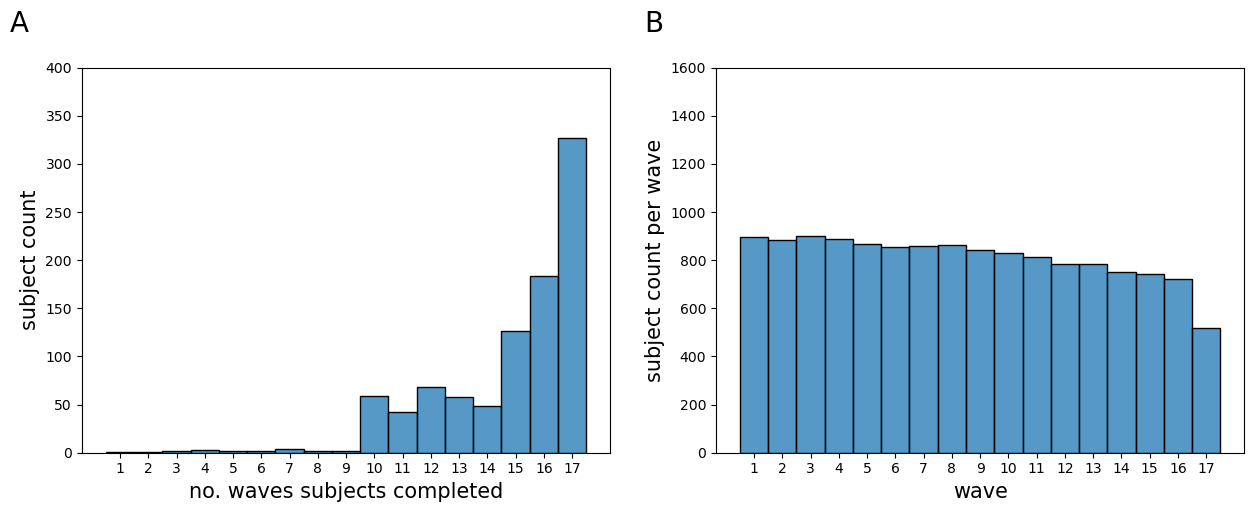

In [14]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

# number of waves completed
sns.histplot(data.PROLIFIC_PID.value_counts(),ax = ax[0], bins = 17, discrete = True)
ax[0].set_xlabel('no. waves subjects completed', fontsize = 15)
ax[0].set_ylabel('subject count', fontsize = 15)
ax[0].set_ylim(0,400)
ax[0].set_xticks(data.wave.unique());
ax[0].set()

# subject count per wave
sns.histplot(data, x = 'wave', ax = ax[1], bins = 17, discrete = True)
ax[1].set_xticks(data.wave.unique());
ax[1].set_xlabel('wave', fontsize = 15)
ax[1].set_ylabel('subject count per wave', fontsize = 15)
ax[1].set_ylim(0,1600)

# add panel label
for i, label in enumerate(['A', 'B']):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
               fontsize=20, va='top', ha='right')
    
img_format = 'png'
fig.savefig(os.path.join(fig_dir, 'subject_wave_counts.' + img_format), format=img_format)


In [15]:
from scipy.stats import chi2_contingency

dataW3 = data.loc[data.wave == 3,['PROLIFIC_PID','ethnicity','race',
                                  'polit_party','sex','agecats', 'loc_description']].reset_index(drop = True)

# Create crosstabulations and perform chi-square tests for all pairs of demographic variables
categorical_vars = ['race','polit_party','sex','agecats','ethnicity','loc_description']

p_vals = pd.DataFrame(columns = categorical_vars, index = categorical_vars)

for i in range(len(categorical_vars)):
    for j in range(i + 1, len(categorical_vars)):
        var1 = categorical_vars[i]
        var2 = categorical_vars[j]
        
        # Create a crosstabulation (contingency table)
        cross_tab = pd.crosstab(dataW3[var1], dataW3[var2])
        
        # Print the names of the variables being tested
        print(f"\nChi-Square Test between {var1} and {var2}:")
        
        # Print the contingency table
        print("Contingency Table:")
        print(cross_tab)
        
        # Perform the chi-square test of independence
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        p_vals.loc[categorical_vars[i], categorical_vars[j]] = p
        
        # Print the chi-square statistic, p-value, degrees of freedom, and expected frequencies
        print("\nChi-Square Statistic:", chi2)
        print("P-Value:", p)
        print("Degrees of Freedom:", dof)
        
        cross_tab.loc['Chi-Square Statistic','stats'] = chi2
        cross_tab.loc['P-Value','stats'] = p
        cross_tab.loc['Degrees of Freedom','stats'] = dof
        
        cross_tab.to_csv(os.path.join(table_dir,'chi_square_test_' + var1 + '_' + var2 + '.csv'))


Chi-Square Test between race and polit_party:
Contingency Table:
polit_party                Democrat  Independent  Republican
race                                                        
Asian                            61           23          11
Black or African American        48           19           1
White                           385          226         127

Chi-Square Statistic: 17.818224088962765
P-Value: 0.001339234225173805
Degrees of Freedom: 4

Chi-Square Test between race and sex:
Contingency Table:
sex                        Female  Male
race                                   
Asian                          41    54
Black or African American      41    27
White                         381   357

Chi-Square Statistic: 4.7517727757223875
P-Value: 0.09293207882569013
Degrees of Freedom: 2

Chi-Square Test between race and agecats:
Contingency Table:
agecats                    age18_24  age25_29  age30_39  age40_44  age45_49  \
race                                       

In [60]:
data.age

4382     55.0
14934    22.0
3007     22.0
3748     48.0
14466    27.0
         ... 
18041    33.0
17877    34.0
7275     30.0
15726    31.0
3829     45.0
Name: age, Length: 13806, dtype: float64

# Demographic Lasso Regressions

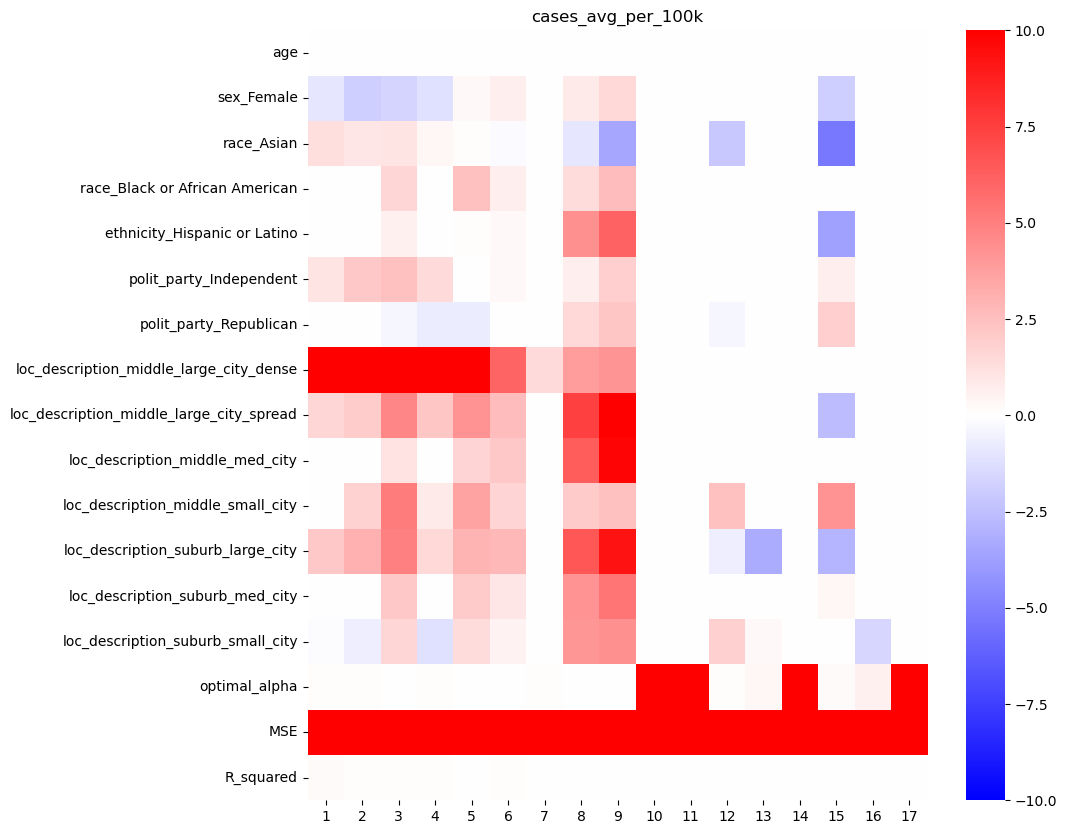

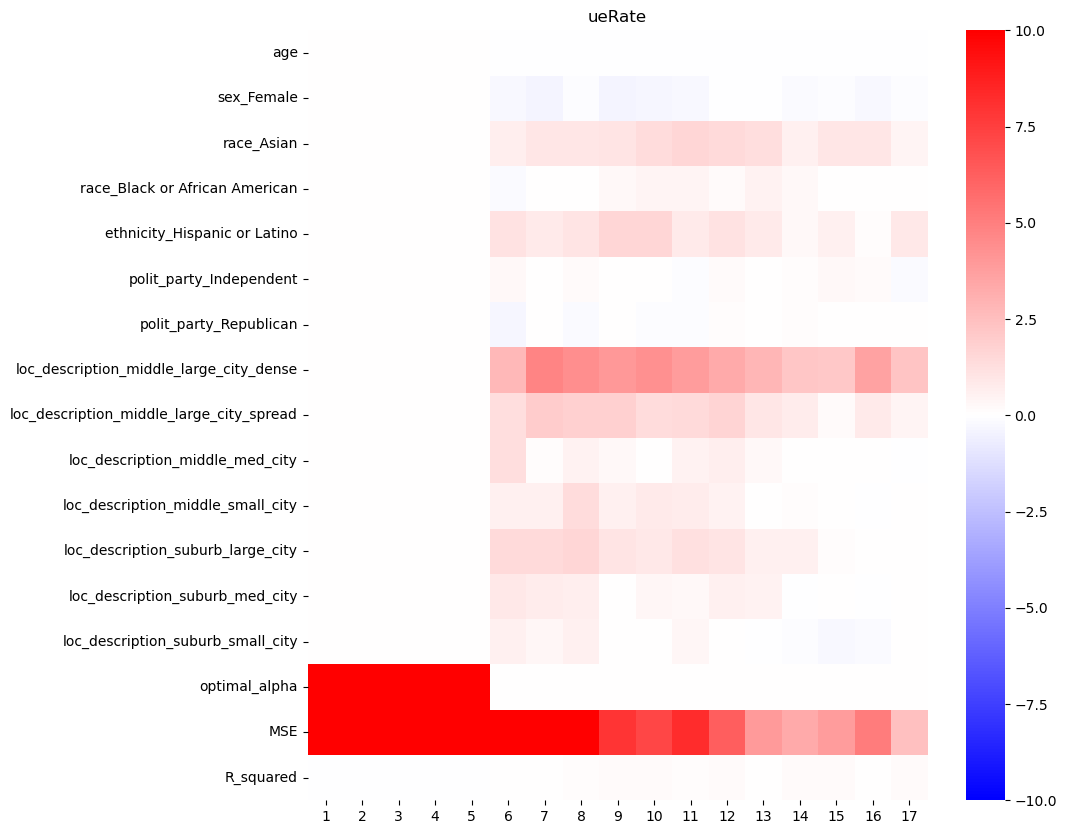

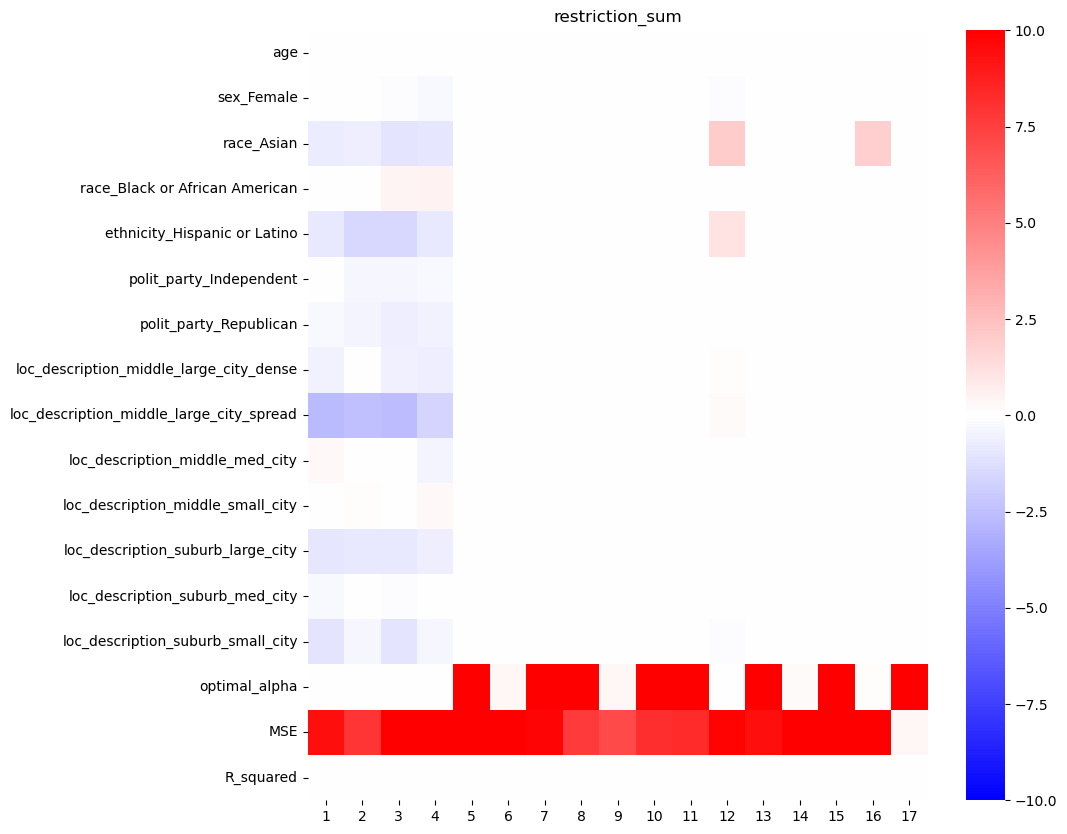

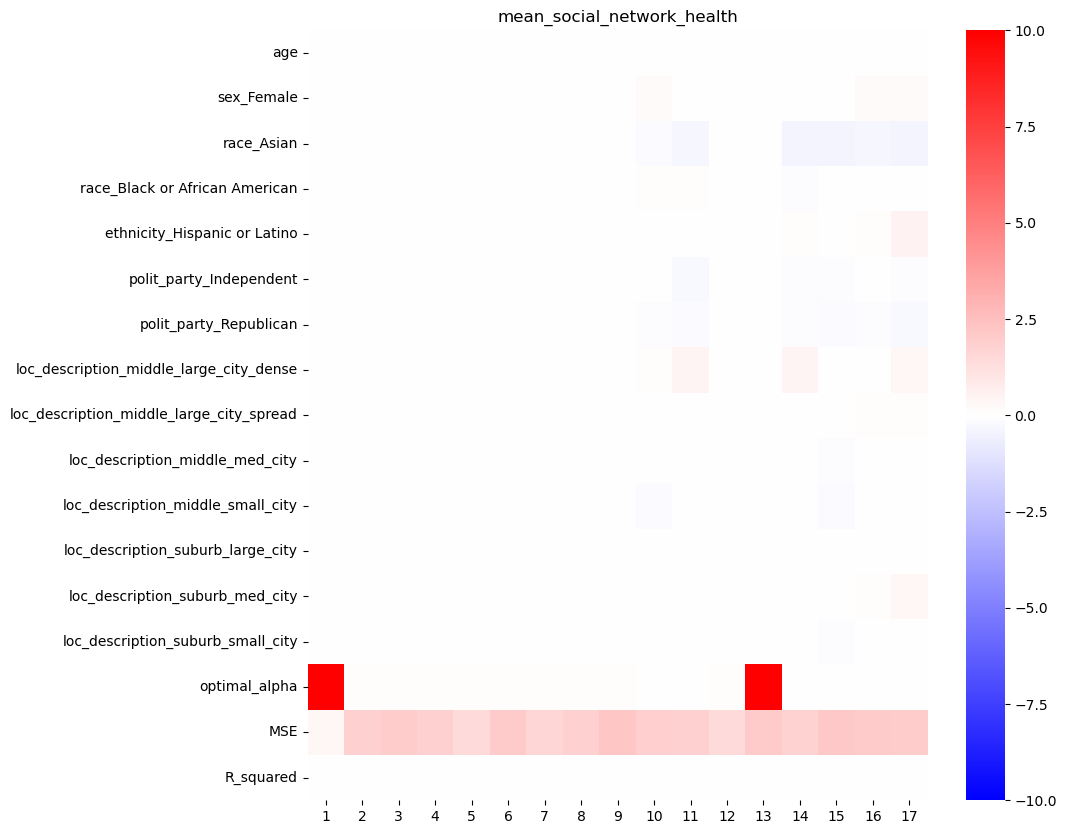

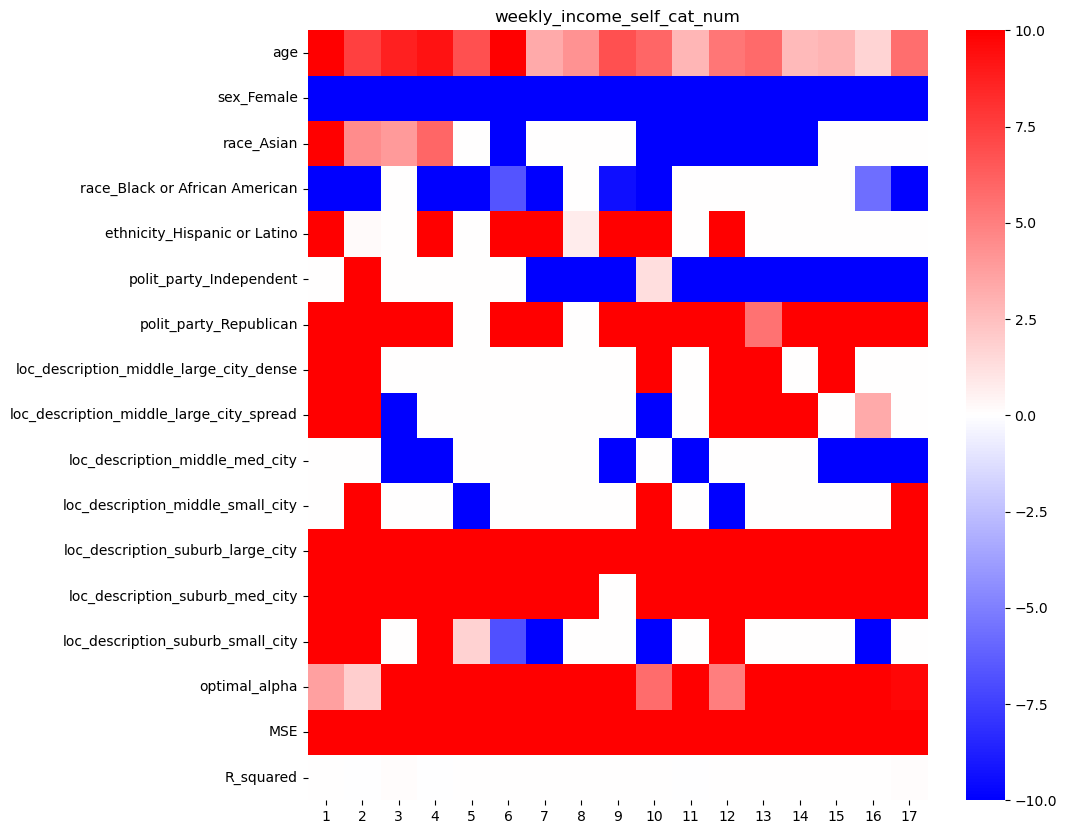

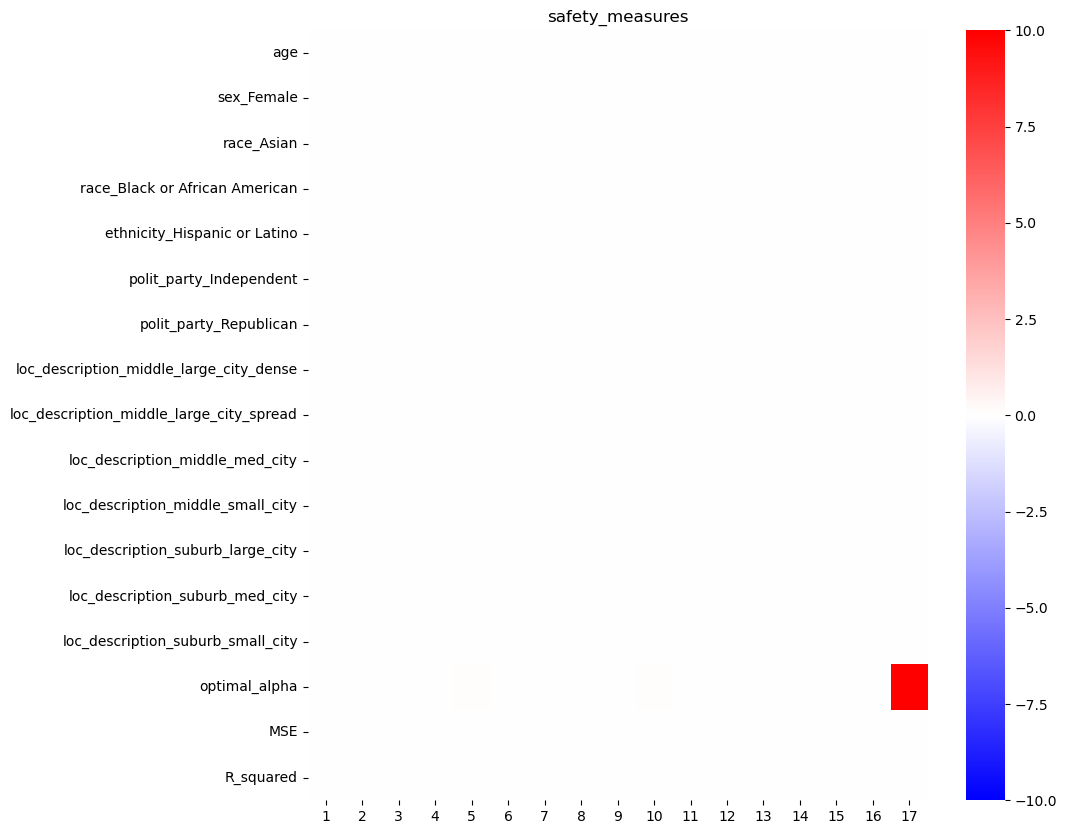

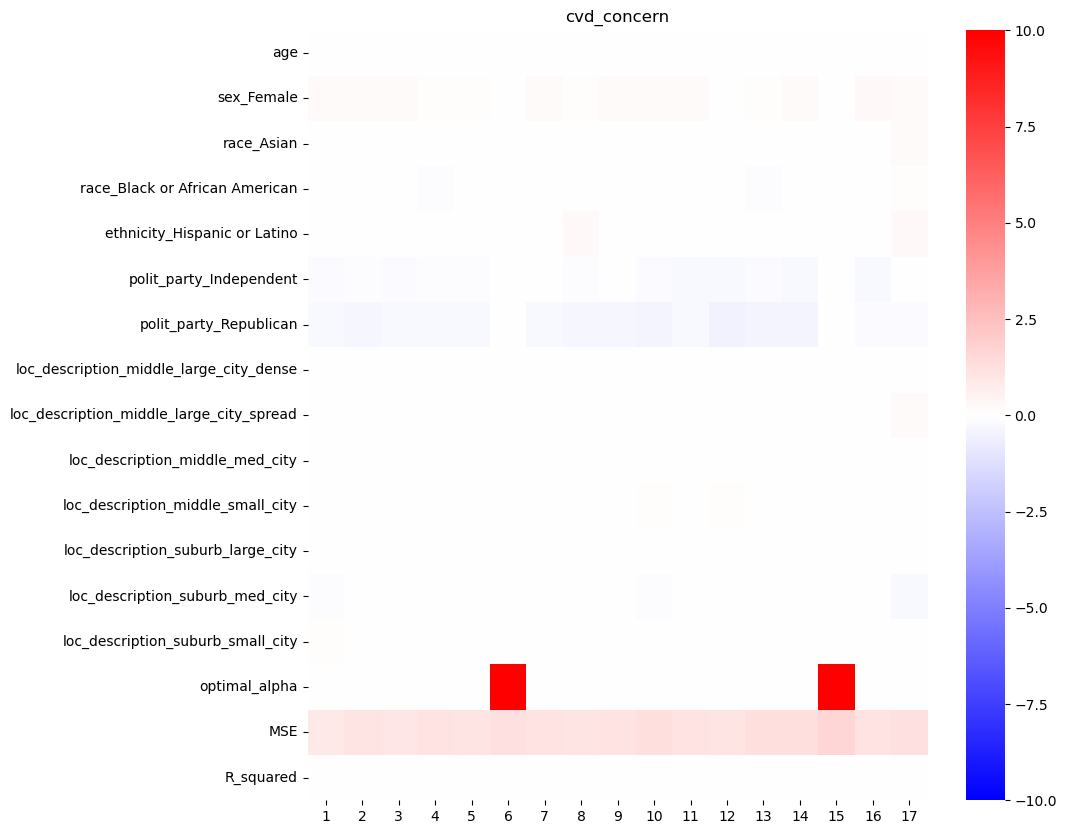

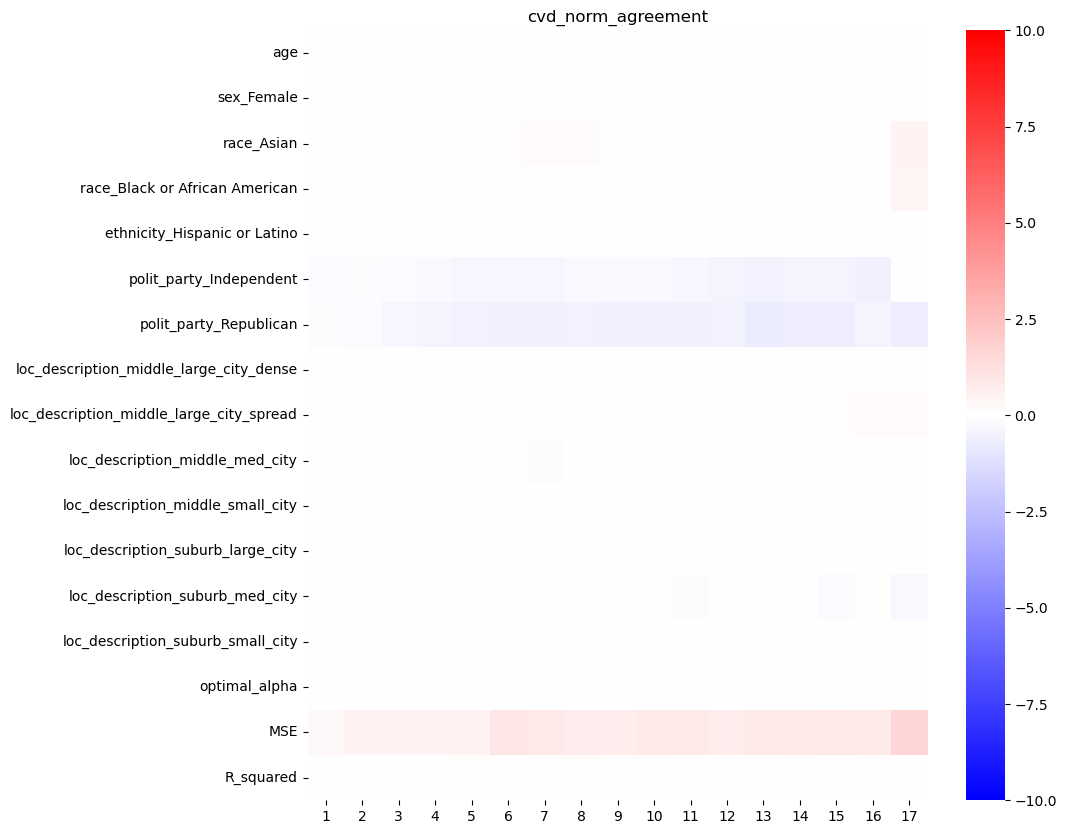

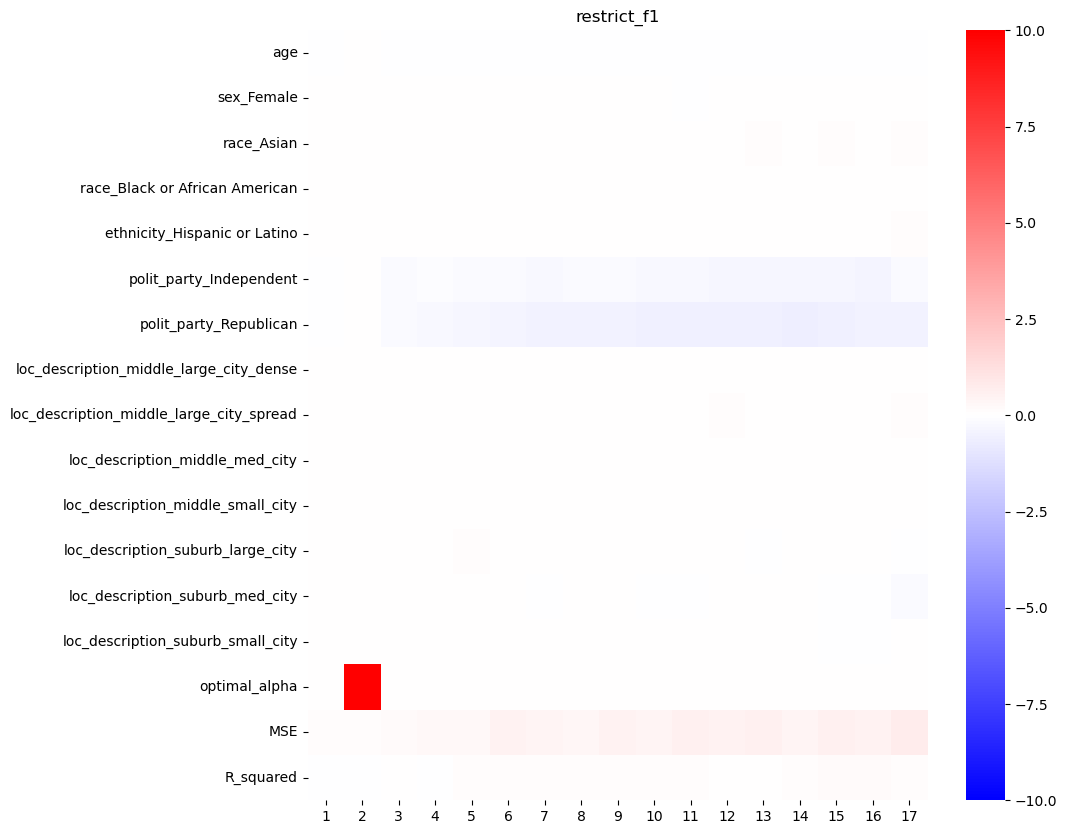

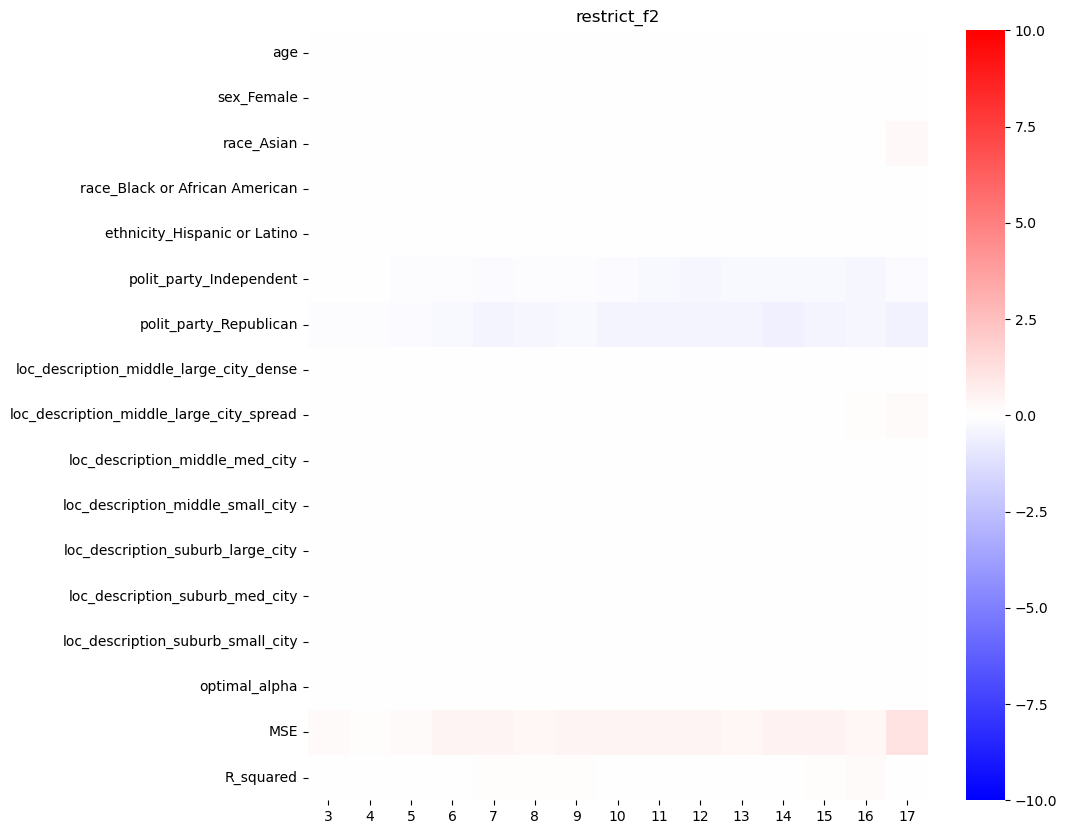

In [66]:
# Load packages
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split


y_vec = ['cases_avg_per_100k','ueRate', 'restriction_sum',
         'mean_social_network_health','weekly_income_self_cat_num','safety_measures',
        'cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2']

waves = list(range(1,18))
wave_restrict2 = list(range(3,18))
for y_var in y_vec:

    if y_var == 'restrict_f2':
        loop_waves = wave_restrict2
    else:
        loop_waves = waves

    for wave in loop_waves:    
        data_singleWave = data.loc[data.wave == wave,[y_var,
                                                      'ethnicity','race',
                                                      'polit_party','sex',
                                                      'loc_description', 'age']].reset_index(drop = True)

        df = data_singleWave.dropna()
#         print(y_var)
#         print(df.head())

         # Encode categorical variables into dummy variables
        df_encoded = pd.get_dummies(df, columns=['sex',
                                                 'race','ethnicity',
                                                 'polit_party','loc_description'])


        # Manually set a reference category 
        reference_category_dict = {'sex': 'Male', 'race': 'White', 
                               'ethnicity': 'Not Hispanic or Latino', 'polit_party': 'Democrat', 
                               'loc_description':'countryside'}
        for ref_cat in list(reference_category_dict.keys()):
            df_encoded.drop(columns=ref_cat+'_'+reference_category_dict[ref_cat], inplace=True)

        # Split the data into predictors (X) and the target variable (y)
        X = df_encoded.drop(y_var, axis=1)
        y = df_encoded[y_var]



        # Split your data into training, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Create a LassoCV model with a range of alpha values
        alphas = np.linspace(0.01, 10, 100)

        lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation

        # Fit the LassoCV model on the training data
        lasso_cv.fit(X_train, y_train)

        # Get the optimal alpha value
        optimal_alpha = lasso_cv.alpha_


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # # Fit a Lasso regression model
        lasso = Lasso(alpha=optimal_alpha)  # You can adjust the alpha (penalty) parameter
        lasso.fit(X_train, y_train)

        # Predict the target variable on the test set
        y_pred = lasso.predict(X_test)

        # Evaluate the model (you can use different metrics)
        from sklearn.metrics import mean_squared_error, r2_score

        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

#         print(f"{feature}: {coef}")
#         print("Mean Squared Error:", mse)
#         print("R-squared:", r_squared)

        # Print the coefficients of the Lasso regression model
        coefficients = lasso.coef_
    #     print("\nLasso Coefficients:")
    #     for feature, coef in zip(X.columns, coefficients):

        if wave == loop_waves[0]:
            coef = pd.DataFrame(index = list(X.columns) + ['optimal_alpha', 'MSE', 'R_squared'], columns = loop_waves)
        coef.loc[list(X.columns),wave] = coefficients
        coef.loc['optimal_alpha',wave] = optimal_alpha
        coef.loc['MSE',wave] = mse
        coef.loc['R_squared',wave] = r_squared
    
    coef.to_csv(os.path.join(table_dir,'dem_lasso_' +y_var+ '.csv'))
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    sns.heatmap(data = coef.astype(float), cmap = 'bwr', vmin = -10, vmax = 10,  ax = ax)
    ax.set_title(y_var)
    img_format = 'svg'
    fig.savefig(os.path.join(fig_dir, 'dem_lasso_' +y_var +'.'+ img_format), format=img_format)

# ALL MEASURES AVERAGE WITHIN SUBJECT CORRELATION 

In [17]:
measures = local_context_vars+personal_experience+attitude_vars
pid_corr = pd.DataFrame(columns = ['pid', 'index_var']+measures)
for pid in data.PROLIFIC_PID.unique():
    if data.loc[data.PROLIFIC_PID==pid].shape[0]>2:
        tmp_df = data.loc[data.PROLIFIC_PID==pid, measures].corr().reset_index()
        tmp_df  = tmp_df.rename(columns = {'index': 'index_var'})
        tmp_df['pid'] = pid
        pid_corr = pd.concat([pid_corr, tmp_df])

pid_corr = pid_corr.groupby(by='index_var').mean(numeric_only = True)
pid_corr = pid_corr.loc[measures,measures]
pid_corr

cases_avg_per_100k    ueRate  restriction_sum  \
index_var                                                                   
cases_avg_per_100k                    1.000000 -0.490239        -0.173045   
ueRate                               -0.490239  1.000000         0.610935   
restriction_sum                      -0.173045  0.610935         1.000000   
mean_social_network_health            0.222596 -0.313830        -0.216781   
weekly_income_self_cat_num           -0.002457  0.005828        -0.005547   
safety_measures                      -0.024663  0.142989         0.128248   
cvd_concern                           0.069124  0.089971         0.147506   
cvd_norm_agreement                   -0.011737  0.271405         0.312569   
restrict_f1                          -0.236368  0.580708         0.510998   
restrict_f2                          -0.045614  0.279776         0.310657   
restrict_f3                          -0.067218  0.184536         0.179702   

                            mean_social_network_health  \
index_var                                                
cases_avg_per_100k                            0.222596   
ueRate                                       -0.313830   
restriction_sum                              -0.216781   
mean_social_network_health                    1.000000   
weekly_income_self_cat_num                   -0.000614   
safety_measures                              -0.032198   
cvd_concern                                  -0.032686   
cvd_norm_agreement                           -0.128087   
restrict_f1                                  -0.262770   
restrict_f2                                  -0.097881   
restrict_f3                                  -0.078523   

                            weekly_income_self_cat_num  safety_measures  \
index_var                                                                 
cases_avg_per_100k                           -0.002457        -0.024663   
ueRate                                        0.005828         0.142989   
restriction_sum                              -0.005547         0.128248   
mean_social_network_health                   -0.000614        -0.032198   
weekly_income_self_cat_num                    1.000000        -0.017614   
safety_measures                              -0.017614         1.000000   
cvd_concern                                  -0.007411         0.112297   
cvd_norm_agreement                           -0.011202         0.270087   
restrict_f1                                  -0.001247         0.160442   
restrict_f2                                  -0.031121         0.280055   
restrict_f3                                   0.005628         0.132852   

                            cvd_concern  cvd_norm_agreement  restrict_f1  \
index_var                                                                  
cases_avg_per_100k             0.069124           -0.011737    -0.236368   
ueRate                         0.089971            0.271405     0.580708   
restriction_sum                0.147506            0.312569     0.510998   
mean_social_network_health    -0.032686           -0.128087    -0.262770   
weekly_income_self_cat_num    -0.007411           -0.011202    -0.001247   
safety_measures                0.112297            0.270087     0.160442   
cvd_concern                    1.000000            0.265189     0.235964   
cvd_norm_agreement             0.265189            1.000000     0.389017   
restrict_f1                    0.235964            0.389017     1.000000   
restrict_f2                    0.272545            0.405721     0.549598   
restrict_f3                    0.161363            0.193405     0.302146   

                            restrict_f2  restrict_f3  
index_var                                             
cases_avg_per_100k            -0.045614    -0.067218  
ueRate                         0.279776     0.184536  
restriction_sum                0.310657     0.179702  
mean_social_network_health    -

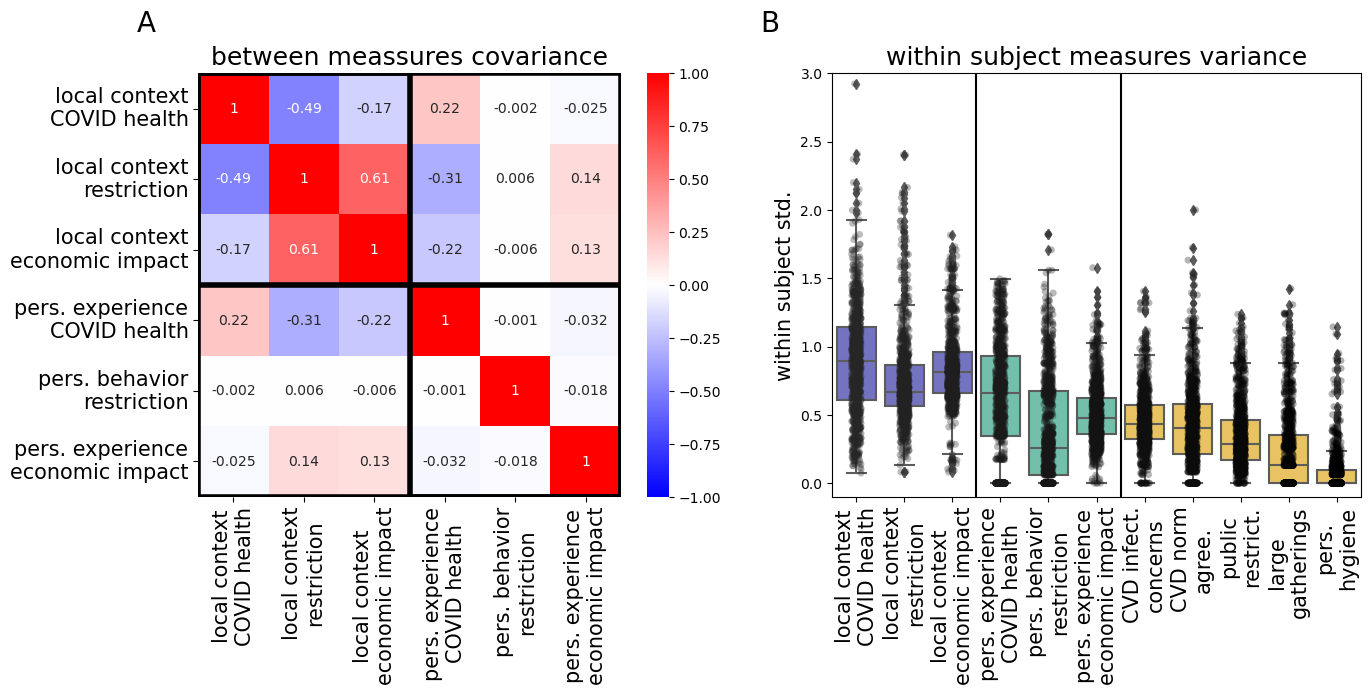

In [18]:
tick_lables = ['local context\nCOVID health', 'local context\nrestriction','local context\neconomic impact',
               'pers. experience\nCOVID health','pers. behavior\nrestriction', 'pers. experience\neconomic impact']
col_include = ['cases_avg_per_100k', 'ueRate', 'restriction_sum',
               'mean_social_network_health', 'weekly_income_self_cat_num','safety_measures']            

tick_lables_with_attitudes = ['local context\nCOVID health', 'local context\nrestriction','local context\neconomic impact',
               'pers. experience\nCOVID health','pers. behavior\nrestriction', 'pers. experience\neconomic impact',
               'CVD infect.\nconcerns', 'CVD norm\nagree.', 'public\nrestrict.', 'large\ngatherings', 'pers.\nhygiene']


fig, ax = plt.subplots(1,2, figsize = (15,5.5))
sns.heatmap(pid_corr.loc[col_include,col_include].round(3),cmap='bwr', annot=True,vmin = -1, vmax = 1,
           yticklabels=tick_lables,  xticklabels=tick_lables, ax = ax[0])
ax[0].set_xticklabels( tick_lables,fontsize = 15);
ax[0].set_yticklabels( tick_lables,fontsize = 15);
ax[0].set_ylabel("")
ax[0].set_title('between meassures covariance',fontsize = 18)


# county level impact measures
ax[0].add_patch(
    patches.Rectangle((0, 0),
                      3,3,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# personal level impact measures
ax[0].add_patch(
    patches.Rectangle((3, 3),
                      3,3,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# overall frame
ax[0].add_patch(
    patches.Rectangle((0, 0),
                      6,6,
                      edgecolor='black',
                      fill=False,
                      lw=4))

# Within subject variance across waves per measure
sns.boxplot(data_zscore[measures+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax[1],
            palette = [[0.4,0.4,0.8], [0.4,0.4,0.8],[0.4,0.4,0.8], 
                        [0.4,0.8,0.7], [0.4,0.8,0.7],[0.4,0.8,0.7], 
                        [1,0.8,0.3], [1,0.8,0.3],[1,0.8,0.3],[1,0.8,0.3], [1,0.8,0.3],])
sns.stripplot(data_zscore[measures+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std(), ax = ax[1], 
                palette='dark:black', alpha = 0.3)
ax[1].set_xticklabels( tick_lables_with_attitudes,rotation = 90, fontsize = 15);
ax[1].set_ylim((-0.1,3));
ax[1].set_ylabel('within subject std.',fontsize = 15)
ax[1].set_title('within subject measures variance',fontsize = 18)
ax[1].plot([2.5,2.5], [-.1,3], c='k')
ax[1].plot([5.5,5.5], [-.1,3], c='k')

for i, label in enumerate(['A', 'B']):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
               fontsize=20, va='top', ha='right')

  
img_format = 'svg'
fig.savefig(os.path.join(fig_dir, 'corrMat_withinSubVar_local_and_personal_conext.' + img_format), format=img_format)


In [19]:
#Chi-Square Test for the Variance: https://www.itl.nist.gov/div898/handbook/eda/section3/eda358.htm
from scipy.stats import chi2

def chi_square_var(sample_sd, sample_N, sigma_target):
    T=(sample_N-1)*(sample_sd/sigma_target)**2
    return T

sigma_target = 0.1
alpha_level = 0.05
for m in measures:
    print('\n' + m)
    sample_sd = data_zscore[[m]+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std().mean().values[0]
    sample_N = len(data_zscore[[m]+['PROLIFIC_PID']].groupby(by = 'PROLIFIC_PID').std())
    T = chi_square_var(sample_sd, sample_N, sigma_target)
    print('chi-square:' + str(T))
    print('df:' + str(sample_N-1))
    crit_val = chi2.ppf(alpha_level, sample_N)
    if T > crit_val:
        print('var ' + m + '< ' + str(sigma_target))
    if T < crit_val:
        print('!!var ' + m + '> ' + str(sigma_target))
        


cases_avg_per_100k
chi-square:80096.79109467761
df:1013
var cases_avg_per_100k< 0.1

ueRate
chi-square:55487.94697444916
df:1013
var ueRate< 0.1

restriction_sum
chi-square:71811.51729938452
df:1013
var restriction_sum< 0.1

mean_social_network_health
chi-square:37917.059184595106
df:1013
var mean_social_network_health< 0.1

weekly_income_self_cat_num
chi-square:14973.794309102012
df:1013
var weekly_income_self_cat_num< 0.1

safety_measures
chi-square:26114.57727956047
df:1013
var safety_measures< 0.1

cvd_concern
chi-square:21663.29258092616
df:1013
var cvd_concern< 0.1

cvd_norm_agreement
chi-square:18533.40581431405
df:1013
var cvd_norm_agreement< 0.1

restrict_f1
chi-square:12168.552052477145
df:1013
var restrict_f1< 0.1

restrict_f2
chi-square:4773.950972831876
df:1013
var restrict_f2< 0.1

restrict_f3
chi-square:462.90729573495565
df:1013
!!var restrict_f3> 0.1


In [20]:
# log transform COVID numbers for potting
data['log_cases_avg_per_100k'] = data['cases_avg_per_100k']
data.loc[data.log_cases_avg_per_100k == 0, 'log_cases_avg_per_100k'] = 0.001
data['log_cases_avg_per_100k'] = np.log(data['log_cases_avg_per_100k'])

In [21]:
# local_context_vars = ['cases_avg_per_100k','ueRate','restriction_sum']
# personal_experience = ['mean_social_network_health','weekly_income_self_cat_num',
#                        'safety_measures']
# attitude_vars = ['cvd_concern','cvd_norm_agreement', 'restrict_f1', 'restrict_f2', 'restrict_f3']

# Restrictions

Text(0.5, 0, '')

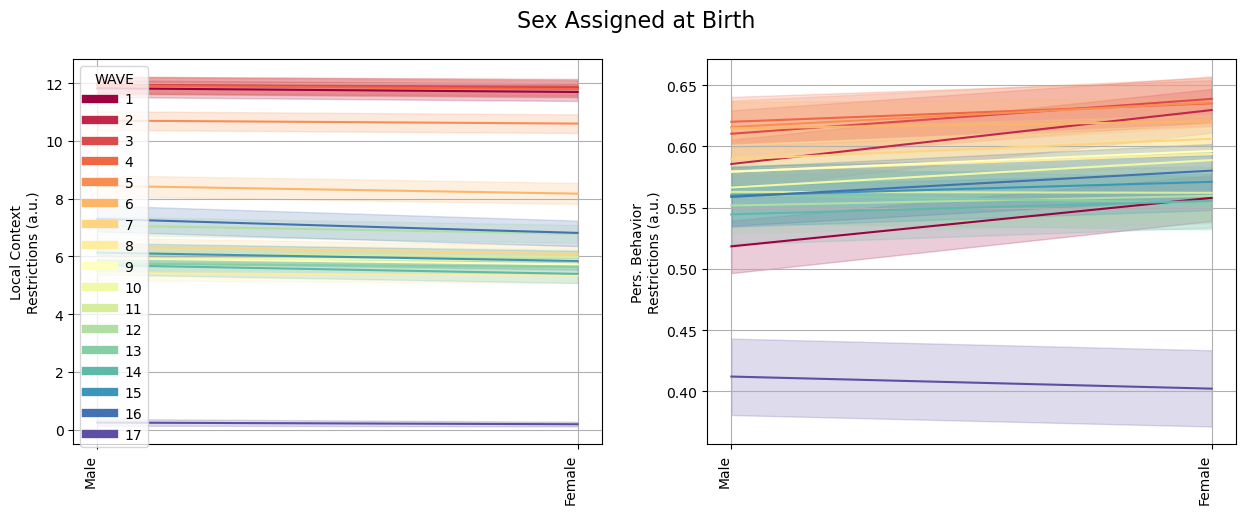

In [22]:
###### sex assigned at birth #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Sex Assigned at Birth', fontsize=16)

# sort data for plotting
custom_dict = {'Male': 0, 'Female': 1}
data = data.sort_values(by=['sex'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'restriction_sum', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'safety_measures', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')


Text(0.5, 0, '')

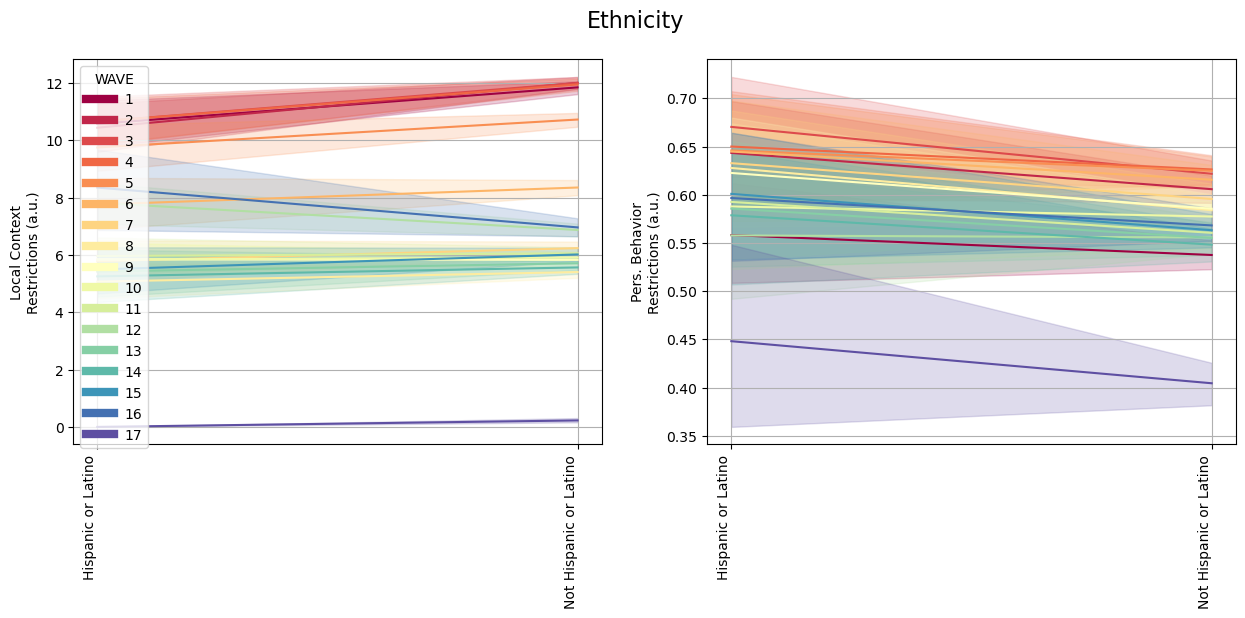

In [23]:
###### ethnicity #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Ethnicity', fontsize=16)

# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'restriction_sum', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'safety_measures', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')


Text(0.5, 0, '')

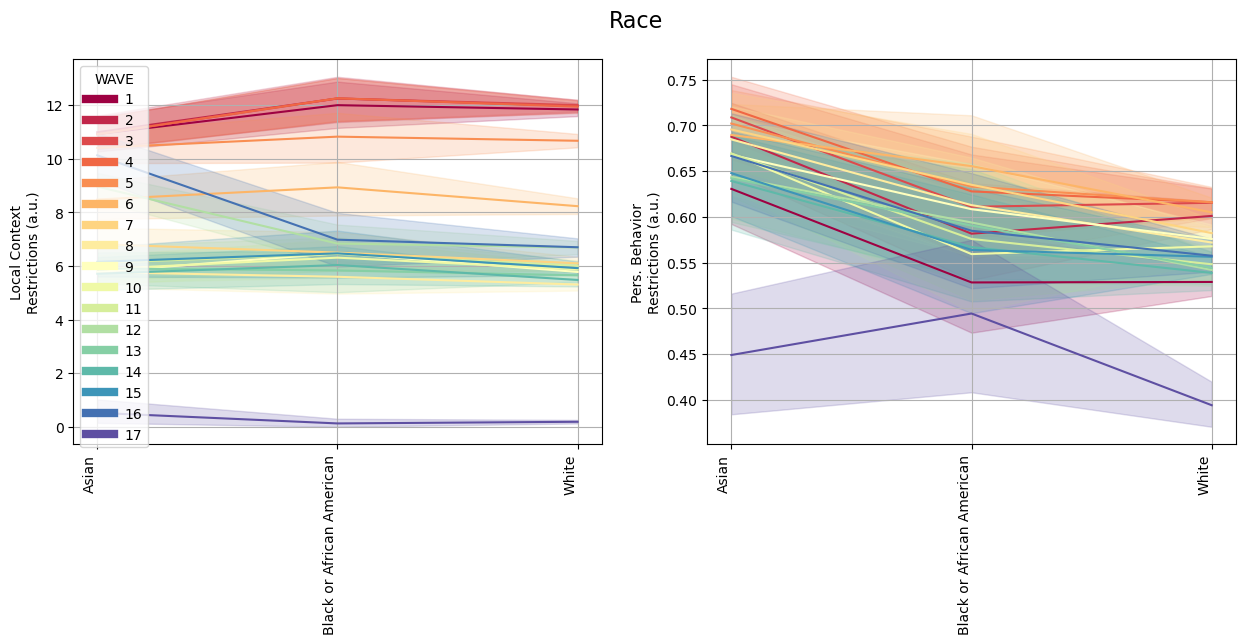

In [24]:
###### race #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Race', fontsize=16)

# Sample includes only 2 Native americans and 1 Pacific Islander, so we're exluding these groups from further analysis 
race_to_include = ['White', 'Asian', 'Black or African American', 'Multiracial', 'Other']
data.loc[data.race.isin(['Prefer not to disclose',
       'Native Hawaiian or Other Pacific Islander',
       'American Indian/Alaska Native']),'race'] = 'Other'
data = data.sort_values(by='race')

# local retsrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



Text(0.5, 0, '')

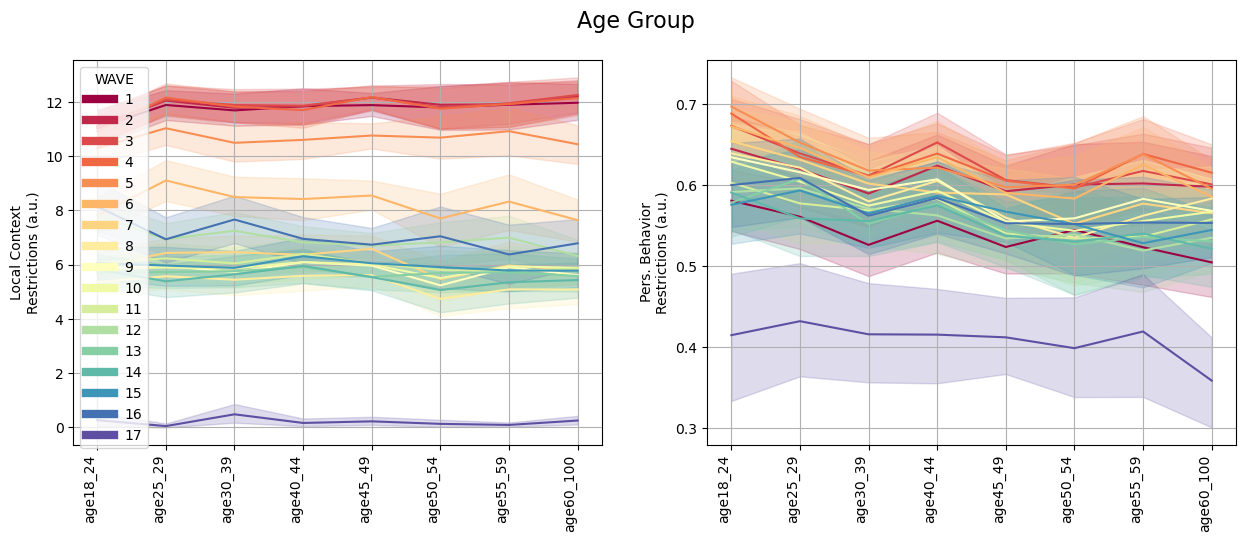

In [27]:
###### age #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Age Group', fontsize=16)



data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)

# local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[1].grid()
ax[1].set_xlabel('')



Text(0.5, 0, '')

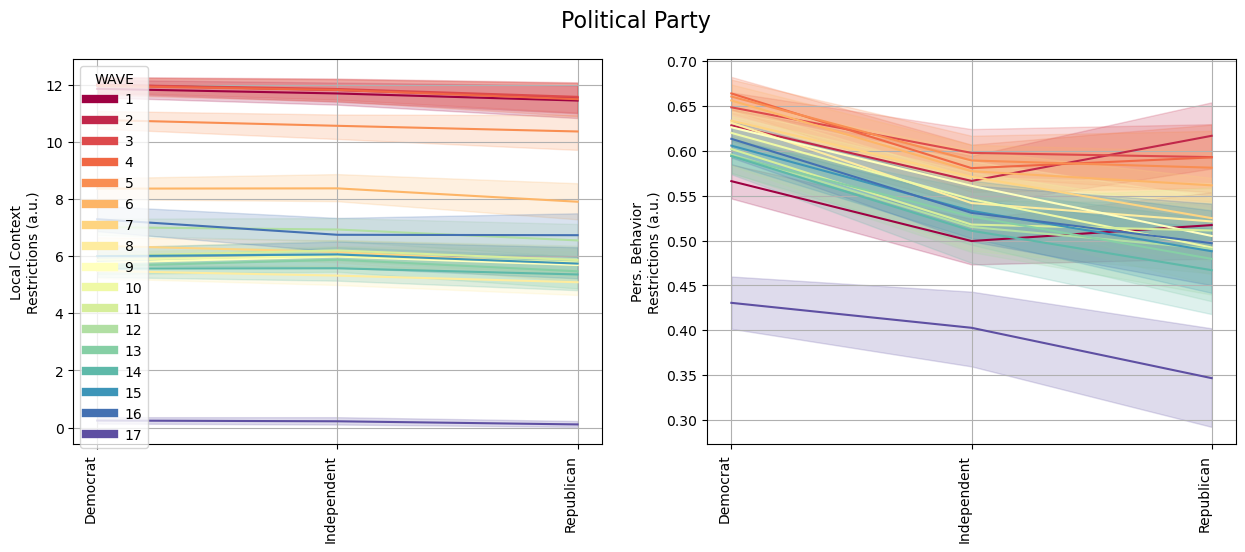

In [28]:
###### Political Party #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Political Party', fontsize=16)

data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))

# local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



Text(0.5, 0, '')

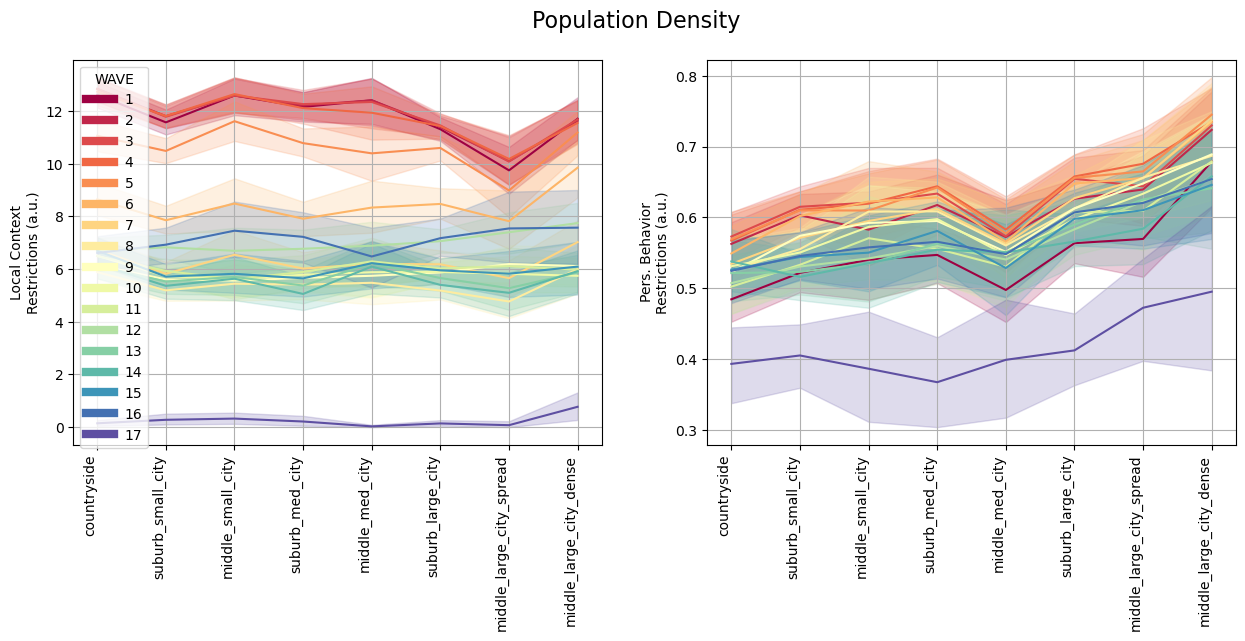

In [31]:
###### Population Density #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Population Density', fontsize=16)

custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))

# Local restrictions
sns.lineplot(data = data,
             y = 'restriction_sum', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nRestrictions (a.u.)')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal restriction behavior
sns.lineplot(data = data,
             y = 'safety_measures', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Behavior\nRestrictions (a.u.)')
ax[1].grid()
ax[1].set_xlabel('')



# COVID HEALTH

Text(0.5, 0, '')

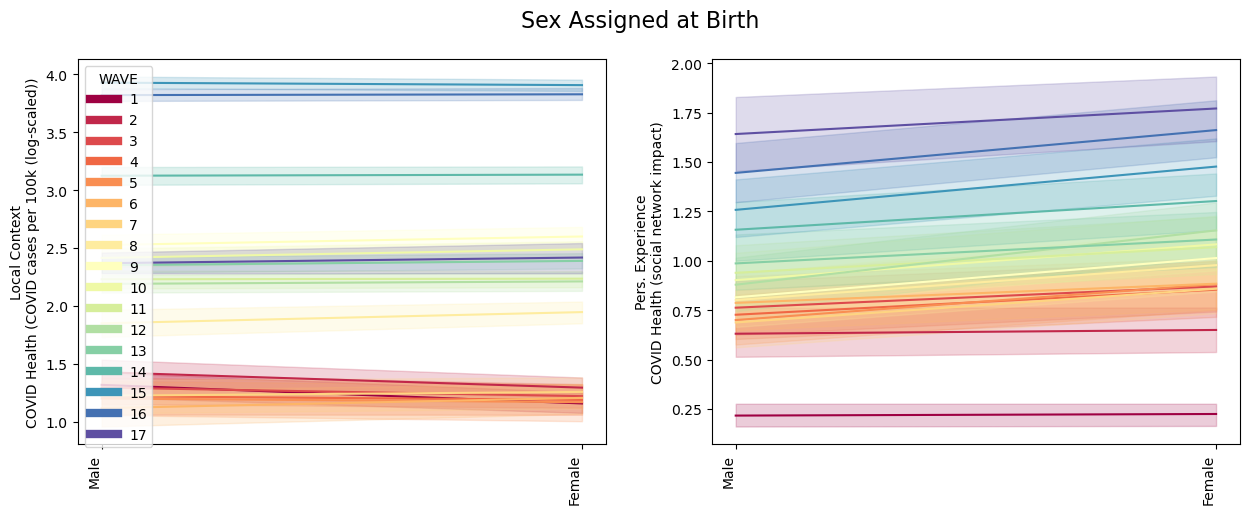

In [32]:
###### Sex Assigned at Birth #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Sex Assigned at Birth', fontsize=16)


# sort data for plotting
custom_dict = {'Male': 0, 'Female': 1}
data = data.sort_values(by=['sex'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'log_cases_avg_per_100k', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# personal Covid Health Impact
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'mean_social_network_health', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].set_xlabel('')



Text(0.5, 0, '')

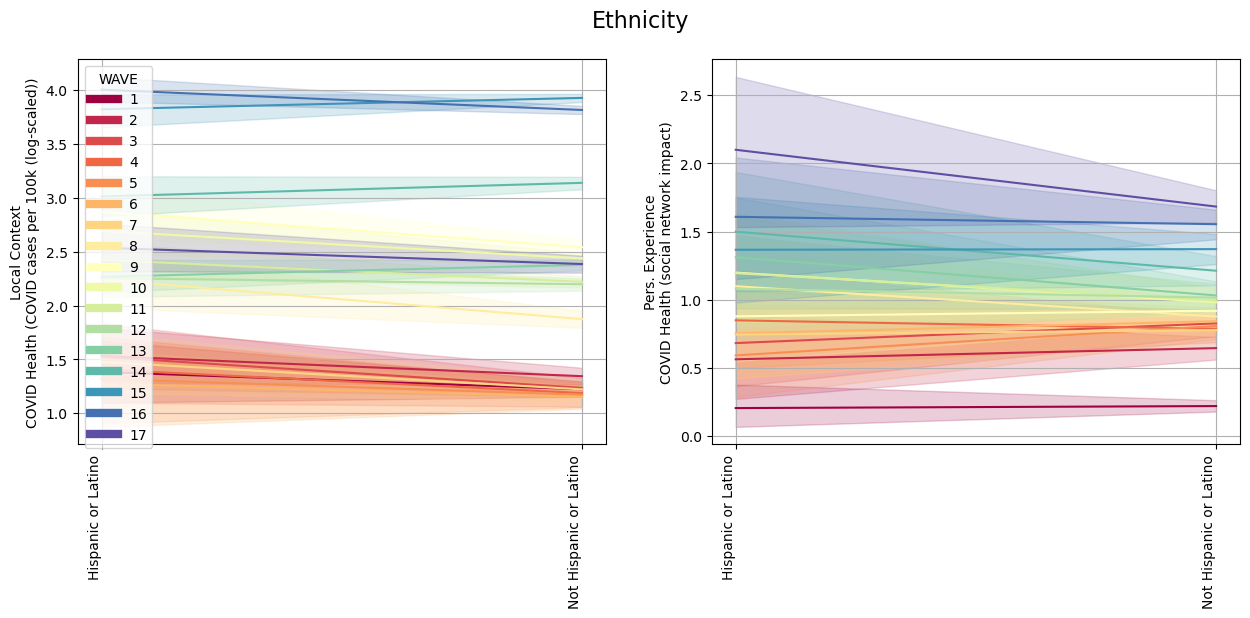

In [33]:
###### Ethnicity #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Ethnicity', fontsize=16)


# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'log_cases_avg_per_100k', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'mean_social_network_health', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')



Text(0.5, 0, '')

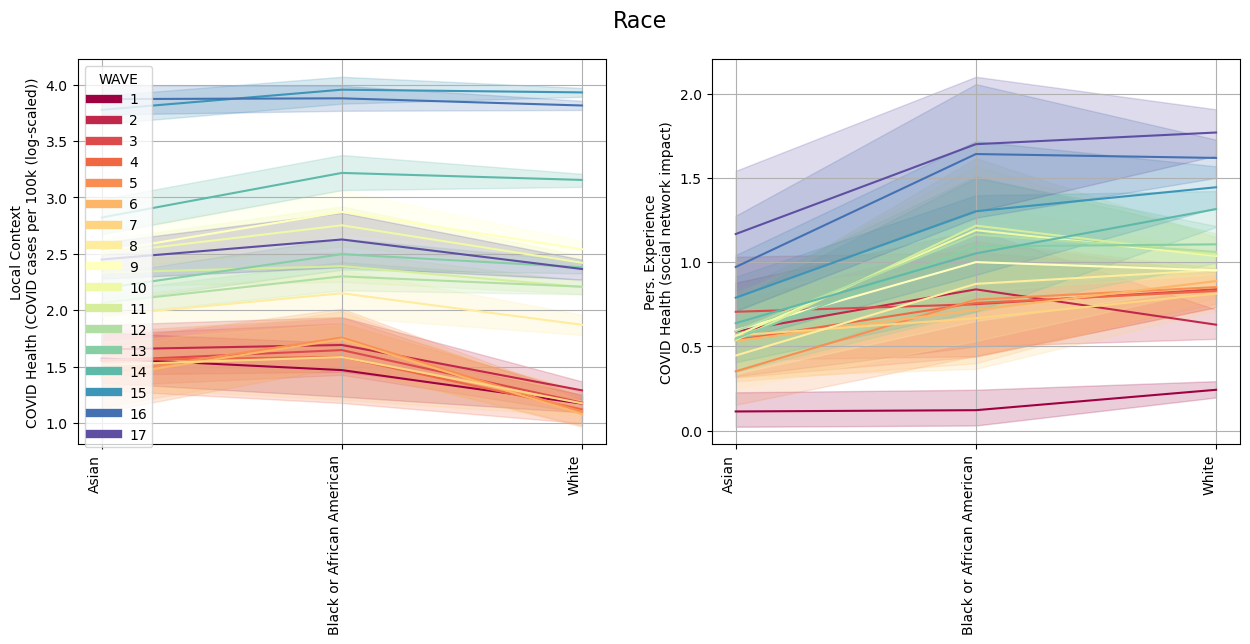

In [35]:
###### Race #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Race', fontsize=16)

data = data.sort_values(by='race')

# local COVID cases
sns.lineplot(data = data, y = 'log_cases_avg_per_100k', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

sns.lineplot(data = data, y = 'mean_social_network_health', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


Text(0.5, 0, '')

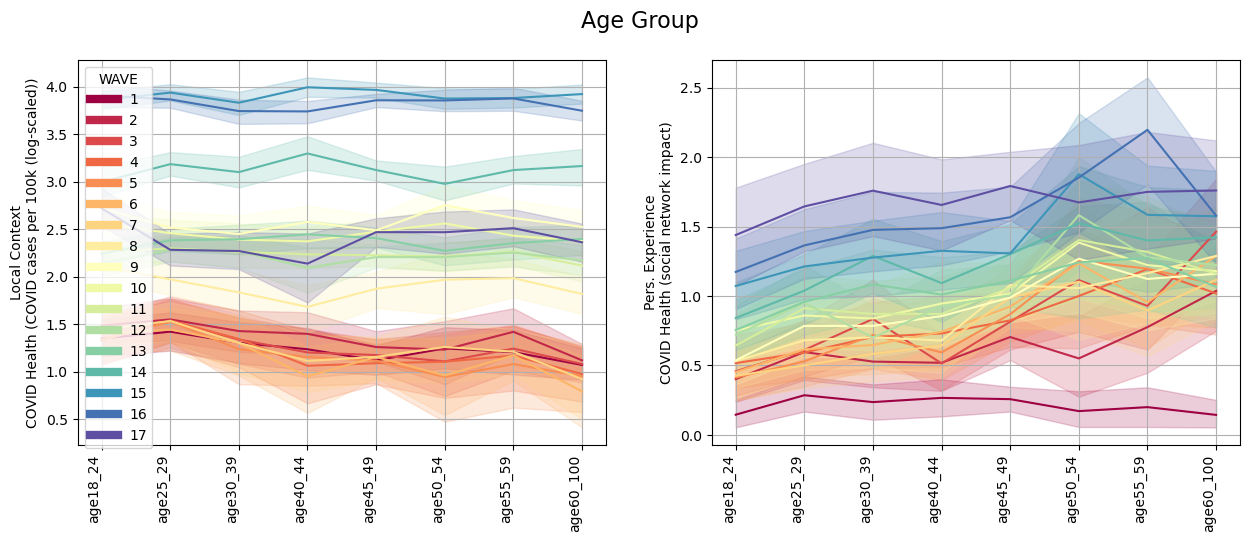

In [36]:
###### Age Group #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Age Group', fontsize=16)

data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)


# local COVID cases
sns.lineplot(data = data, y = 'log_cases_avg_per_100k', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].set_xticks(ticks = list(agecat_numeric_dict.values()), labels = list(agecat_numeric_dict.keys()));
ax[1].grid()
ax[1].set_xlabel('')


Text(0.5, 0, '')

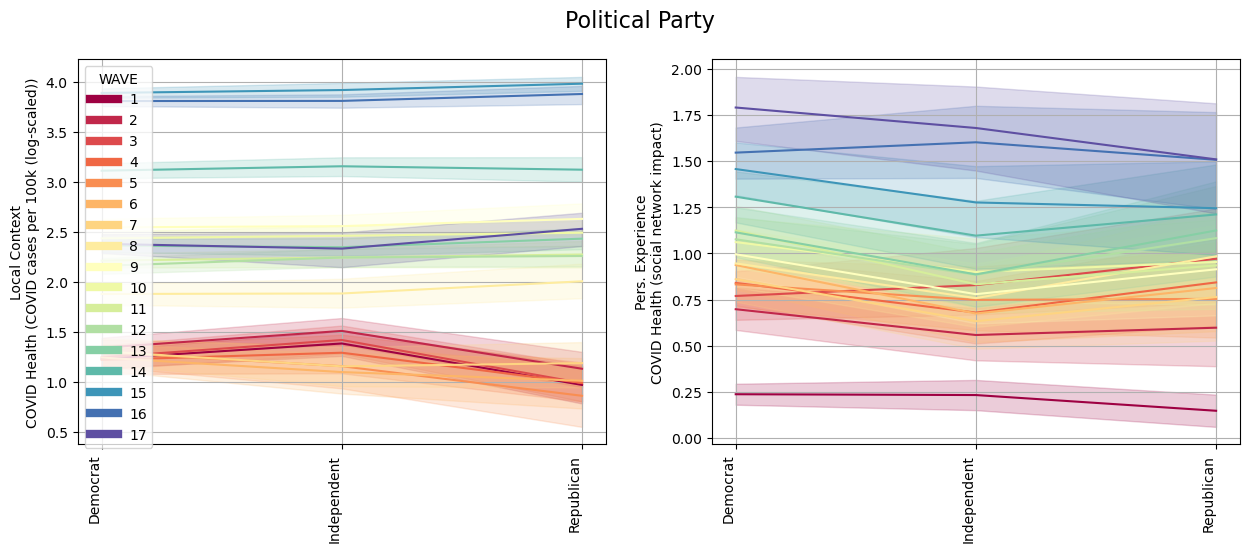

In [37]:
###### Political Party #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Political Party', fontsize=16)

data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))


# local COVID cases
sns.lineplot(data = data, y = 'log_cases_avg_per_100k', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[0], legend='full')
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


Text(0.5, 0, '')

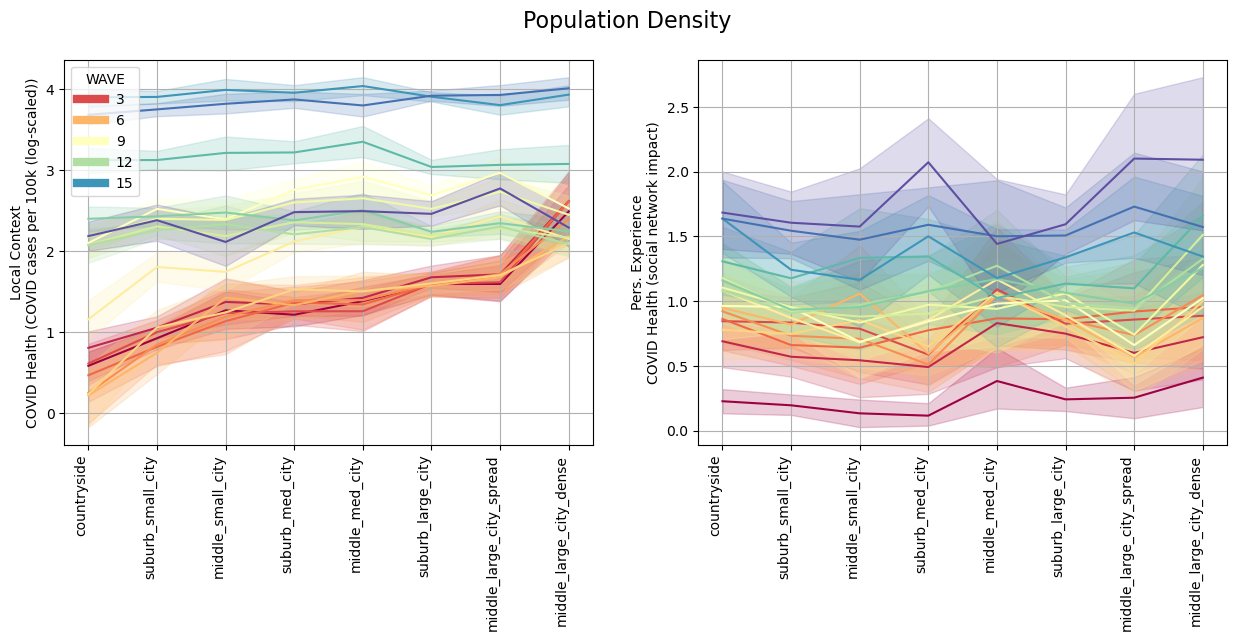

In [39]:
###### Population Density #####

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Population Density', fontsize=16)


custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))


# local COVID cases
sns.lineplot(data = data, y = 'log_cases_avg_per_100k', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[0])
plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right");
ax[0].set_ylabel('Local Context\nCOVID Health (COVID cases per 100k (log-scaled))')
ax[0].grid()
ax[0].set_xlabel('')
leg = ax[0].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


sns.lineplot(data = data, y = 'mean_social_network_health', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = ax[1], legend=False)
plt.setp(ax[1].get_xticklabels(), rotation=90, ha="right");
ax[1].set_ylabel('Pers. Experience\nCOVID Health (social network impact)')
ax[1].grid()
ax[1].set_xlabel('')


# ECONOMIC IMPACT

In [40]:
colormap = sns.cubehelix_palette(as_cmap=True)
cat_colors = [colormap(0), colormap(50),
            colormap(100), colormap(150),
            colormap(200), colormap(250)]

Text(0.5, 0, 'wave')

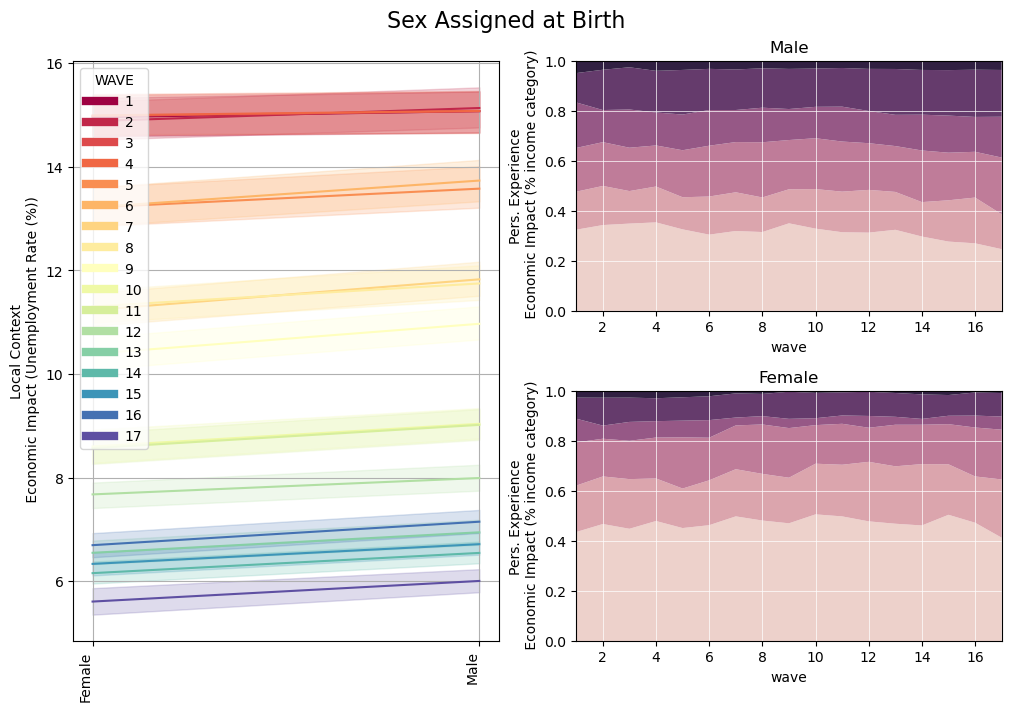

In [41]:
###### Sex Assigned at Birth #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Sex Assigned at Birth', fontsize=16)
colormap = plt.cm.get_cmap('Set2')


# local COVID cases
sns.lineplot(data = data.loc[data.sex.isin(['Male', 'Female'])],
             y = 'ueRate', x = 'sex',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)


data_tmp = data.loc[data.sex.isin(['Male']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_male = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.sex.isin(['Female']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_female = income_counts.div(income_counts.sum(axis=1), axis=0) 


# Male
axd[0].stackplot(income_percentages_male.index,
                income_percentages_male['<$250'], income_percentages_male['$250 - $499'],
                income_percentages_male['$500 - $999'], income_percentages_male['$1000 -$1499'],
                income_percentages_male['$1500 - $2999'], income_percentages_male['>$3000'], 
                colors=cat_colors, zorder=1)
 

# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Male')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[0].set_xlabel('wave')

# Female
axd[1].stackplot(income_percentages_female.index,
                income_percentages_female['<$250'], income_percentages_female['$250 - $499'],
                income_percentages_female['$500 - $999'], income_percentages_female['$1000 -$1499'],
                income_percentages_female['$1500 - $2999'], income_percentages_female['>$3000'], 
                colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Female')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_xlabel('wave')


Text(0.5, 0, 'wave')

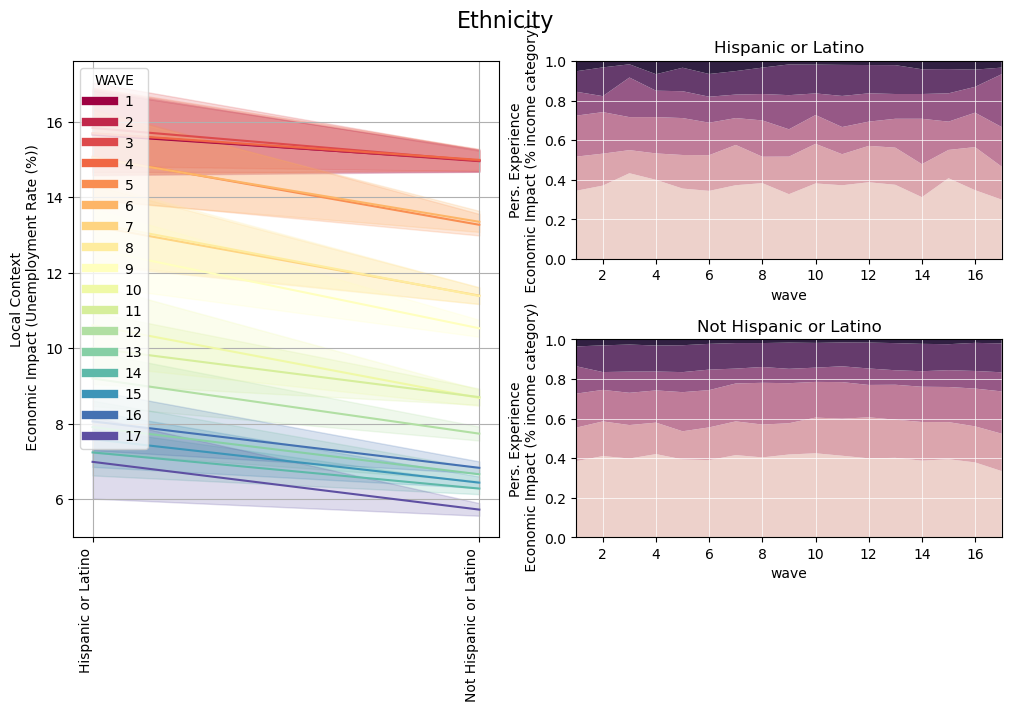

In [42]:
###### Ethnicity #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Ethnicity', fontsize=16)
colormap = plt.cm.get_cmap('Set2')

# Ethnicity: prefer not to disclose N = 6-> drop from visualization
# sort data for plotting
custom_dict = {'Hispanic or Latino': 0, 'Not Hispanic or Latino': 1}
data = data.sort_values(by=['ethnicity'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data.loc[data.ethnicity.isin(['Hispanic or Latino', 'Not Hispanic or Latino'])],
             y = 'ueRate', x = 'ethnicity',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

data_tmp = data.loc[data.ethnicity.isin(['Hispanic or Latino']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_hisp = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.ethnicity.isin(['Not Hispanic or Latino']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_not_hisp = income_counts.div(income_counts.sum(axis=1), axis=0) 
tmp_perc_data = income_percentages_not_hisp


# Hispanic or Latino
axd[0].stackplot(income_percentages_hisp.index,
                income_percentages_hisp['<$250'], income_percentages_hisp['$250 - $499'],
               income_percentages_hisp['$500 - $999'], income_percentages_hisp['$1000 -$1499'],
               income_percentages_hisp['$1500 - $2999'], income_percentages_hisp['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Hispanic or Latino')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[0].set_xlabel('wave')

# Not Hispanic or Latino
axd[1].stackplot(income_percentages_not_hisp.index,
                income_percentages_not_hisp['<$250'], income_percentages_not_hisp['$250 - $499'],
               income_percentages_not_hisp['$500 - $999'], income_percentages_not_hisp['$1000 -$1499'],
               income_percentages_not_hisp['$1500 - $2999'], income_percentages_not_hisp['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Not Hispanic or Latino')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_xlabel('wave')


(1.0, 17.0)

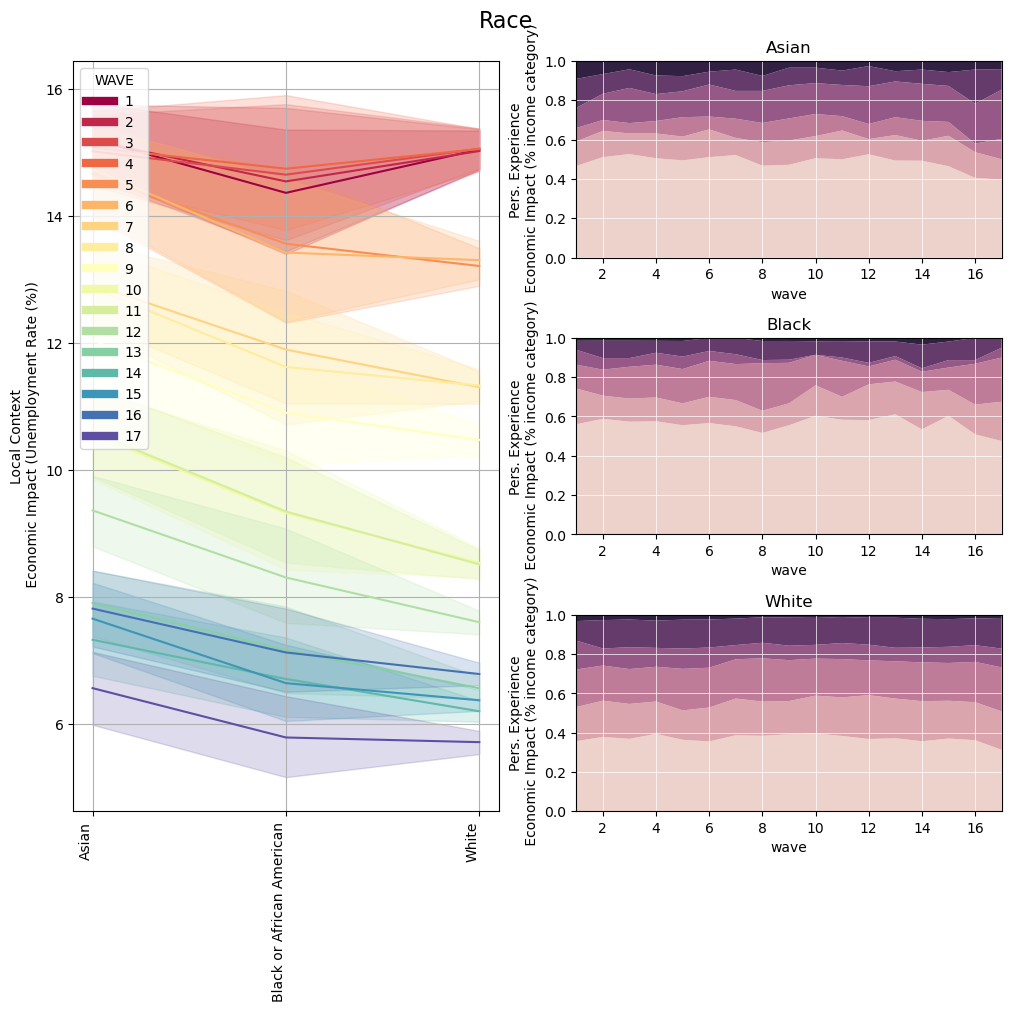

In [45]:
###### Race #####

fig, axd = plt.subplot_mosaic([['left', 0],
                               ['left', 1],
                               ['left', 2]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Race', fontsize=16)

# sort data for plotting
data = data.sort_values(by=['race'])

sns.lineplot(data = data,
             y = 'ueRate', x = 'race',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')

data_tmp = data.loc[data.race.isin(['Asian']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_asian = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.race.isin(['Black or African American']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_black = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.race.isin(['White']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_white = income_counts.div(income_counts.sum(axis=1), axis=0) 
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# Asian
axd[0].stackplot(income_percentages_asian.index,
                income_percentages_asian['<$250'], income_percentages_asian['$250 - $499'],
               income_percentages_asian['$500 - $999'], income_percentages_asian['$1000 -$1499'],
               income_percentages_asian['$1500 - $2999'], income_percentages_asian['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Asian')
axd[0].set_ylim([0,1])
axd[0].set_xlabel('wave')
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Black
axd[1].stackplot(income_percentages_black.index,
                income_percentages_black['<$250'], income_percentages_black['$250 - $499'],
               income_percentages_black['$500 - $999'], income_percentages_black['$1000 -$1499'],
               income_percentages_black['$1500 - $2999'], income_percentages_black['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Black')
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[1].set_xlabel('wave')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])

# White
axd[2].stackplot(income_percentages_white.index,
                income_percentages_white['<$250'], income_percentages_white['$250 - $499'],
               income_percentages_white['$500 - $999'], income_percentages_white['$1000 -$1499'],
               income_percentages_white['$1500 - $2999'], income_percentages_white['>$3000'], 
               colors=cat_colors, zorder=1)

# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[2].set_title('White')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')
axd[2].set_xlabel('wave')
axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

(1.0, 17.0)

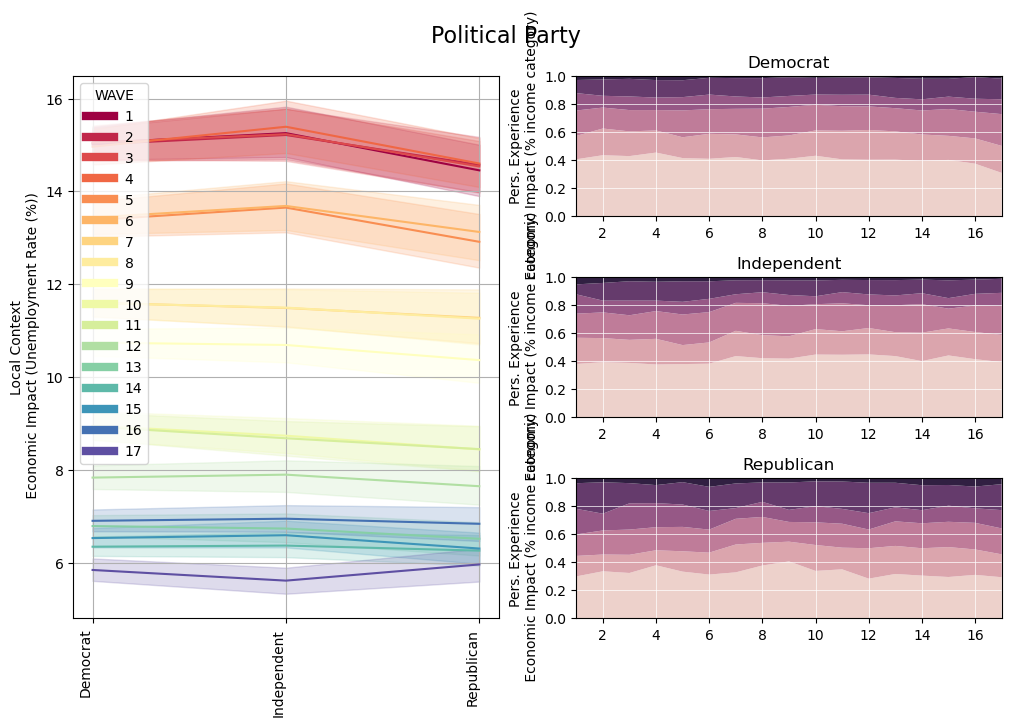

In [47]:
###### Political Party #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2]],
                              figsize=(10,7), layout="constrained")
fig.suptitle('Political Party', fontsize=16)


# sort data for plotting
data = data.sort_values(by='polit_party')
custom_dict = {'Democrat': 0, 'Independent': 1,'Republican': 2,'Other': 3  }
data = data.sort_values(by=['polit_party'], key=lambda x: x.map(custom_dict))

# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'polit_party',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')

data_tmp = data.loc[data.polit_party.isin(['Democrat']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_dem = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Independent']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_indep = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Republican']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_repu = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.polit_party.isin(['Other']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_other = income_counts.div(income_counts.sum(axis=1), axis=0) 
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)

# Democrat
axd[0].stackplot(income_percentages_dem.index,
                income_percentages_dem['<$250'], income_percentages_dem['$250 - $499'],
               income_percentages_dem['$500 - $999'], income_percentages_dem['$1000 -$1499'],
               income_percentages_dem['$1500 - $2999'], income_percentages_dem['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[0].set_title('Democrat')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_indep.index,
                income_percentages_indep['<$250'], income_percentages_indep['$250 - $499'],
               income_percentages_indep['$500 - $999'], income_percentages_indep['$1000 -$1499'],
               income_percentages_indep['$1500 - $2999'], income_percentages_indep['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[1].set_title('Independent')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_repu.index,
                income_percentages_repu['<$250'], income_percentages_repu['$250 - $499'],
               income_percentages_repu['$500 - $999'], income_percentages_repu['$1000 -$1499'],
               income_percentages_repu['$1500 - $2999'], income_percentages_repu['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

axd[2].set_title('Republican')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])


/var/folders/fc/_2yc799j3dq5tc6c7h7f9z5c0000gn/T/ipykernel_65114/2998532685.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(axd['left'].set_xticklabels(['countryside',


(1.0, 17.0)

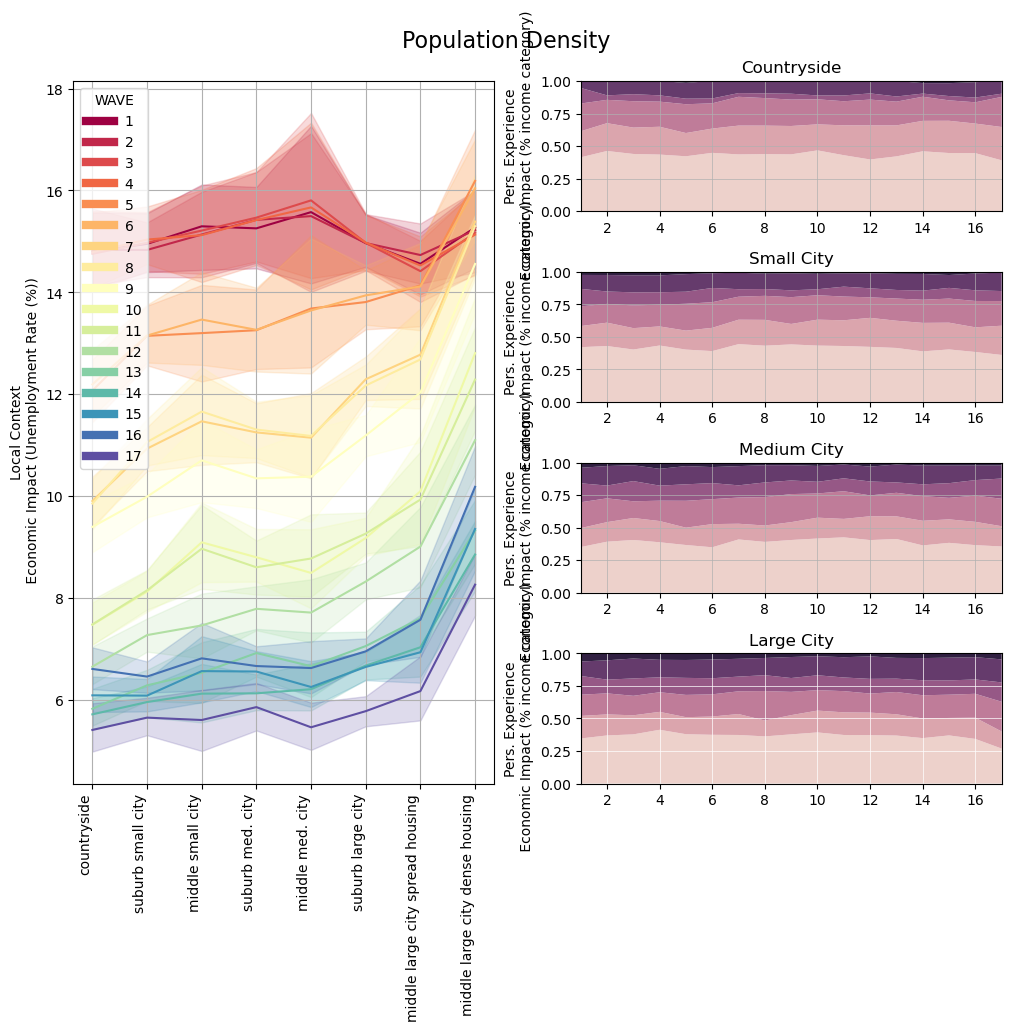

In [49]:
###### Population Density #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2],
                              ['left', 3]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Population Density', fontsize=16)


# sort data for plotting
custom_dict = {'countryside': 0, 'suburb_small_city': 1,'middle_small_city':2,
               'suburb_med_city': 3,'middle_med_city':4,
               'suburb_large_city':5,'middle_large_city_spread':6, 'middle_large_city_dense':7 }
data = data.sort_values(by=['loc_description'], key=lambda x: x.map(custom_dict))



# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'loc_description',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
plt.setp(axd['left'].get_xticklabels(), rotation=90, ha="right");
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
axd['left'].set_xlabel('')
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)
plt.setp(axd['left'].set_xticklabels(['countryside',
                                      'suburb small city',
                                      'middle small city',
                                      'suburb med. city',
                                      'middle med. city',
                                      'suburb large city',
                                      'middle large city spread housing',
                                      'middle large city dense housing']), rotation=90, ha="right");




data_tmp = data.loc[data.loc_description.isin(['countryside']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_country = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_small_city','middle_small_city']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_small_city = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_med_city','middle_med_city']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_med_city = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.loc_description.isin(['suburb_large_city','middle_large_city_spread','middle_large_city_dense']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_large_city = income_counts.div(income_counts.sum(axis=1), axis=0) 

# countryside
axd[0].stackplot(income_percentages_country.index,
                income_percentages_country['<$250'], income_percentages_country['$250 - $499'],
               income_percentages_country['$500 - $999'], income_percentages_country['$1000 -$1499'],
               income_percentages_country['$1500 - $2999'], income_percentages_country['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[0].set_title('Countryside')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_small_city.index,
                income_percentages_small_city['<$250'], income_percentages_small_city['$250 - $499'],
               income_percentages_small_city['$500 - $999'], income_percentages_small_city['$1000 -$1499'],
               income_percentages_small_city['$1500 - $2999'], income_percentages_small_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[1].set_title('Small City')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_med_city.index,
                income_percentages_med_city['<$250'], income_percentages_med_city['$250 - $499'],
               income_percentages_med_city['$500 - $999'], income_percentages_med_city['$1000 -$1499'],
               income_percentages_med_city['$1500 - $2999'], income_percentages_med_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[2].set_title('Medium City')
axd[2].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

# Other
axd[3].stackplot(income_percentages_large_city.index,
                income_percentages_large_city['<$250'], income_percentages_large_city['$250 - $499'],
               income_percentages_large_city['$500 - $999'], income_percentages_large_city['$1000 -$1499'],
               income_percentages_large_city['$1500 - $2999'], income_percentages_large_city['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[3].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[3].set_zorder(2)

axd[3].set_title('Large City')
axd[3].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[3].set_ylim([0,1])
axd[3].set_xlim([1,17])

In [53]:
income_percentages_50_59

weekly_income_self_cat  $1000 -$1499  $1500 - $2999  $250 - $499  $500 - $999  \
wave                                                                            
1                           0.157143       0.085714     0.135714     0.185714   
2                           0.095588       0.147059     0.139706     0.169118   
3                           0.142857       0.121429     0.128571     0.192857   
4                           0.125000       0.110294     0.080882     0.205882   
5                           0.120301       0.150376     0.090226     0.225564   
6                           0.088889       0.170370     0.125926     0.214815   
7                           0.125926       0.111111     0.155556     0.192593   
8                           0.109489       0.131387     0.116788     0.226277   
9                           0.083333       0.143939     0.159091     0.196970   
10                          0.093750       0.125000     0.164062     0.187500   
11                          0.153846       0.115385     0.138462     0.176923   
12                          0.148438       0.132812     0.140625     0.132812   
13                          0.096774       0.145161     0.161290     0.169355   
14                          0.103175       0.126984     0.214286     0.174603   
15                          0.131148       0.106557     0.172131     0.163934   
16                          0.131148       0.106557     0.172131     0.147541   
17                          0.122222       0.100000     0.144444     0.222222   

weekly_income_self_cat     <$250    >$3000  
wave                                        
1                       0.350000  0.085714  
2                       0.382353  0.066176  
3                       0.364286  0.050000  
4                       0.411765  0.066176  
5                       0.338346  0.075188  
6                       0.348148  0.051852  
7                       0.370370  0.044444  
8                       0.379562  0.036496  
9                       0.386364  0.030303  
10                      0.382812  0.046875  
11                      0.400000  0.015385  
12                      0.414062  0.031250  
13                      0.395161  0.032258  
14                      0.349206  0.031746  
15                      0.385246  0.040984  
16                      0.409836  0.032787  
17                      0.377778  0.033333

(1.0, 17.0)

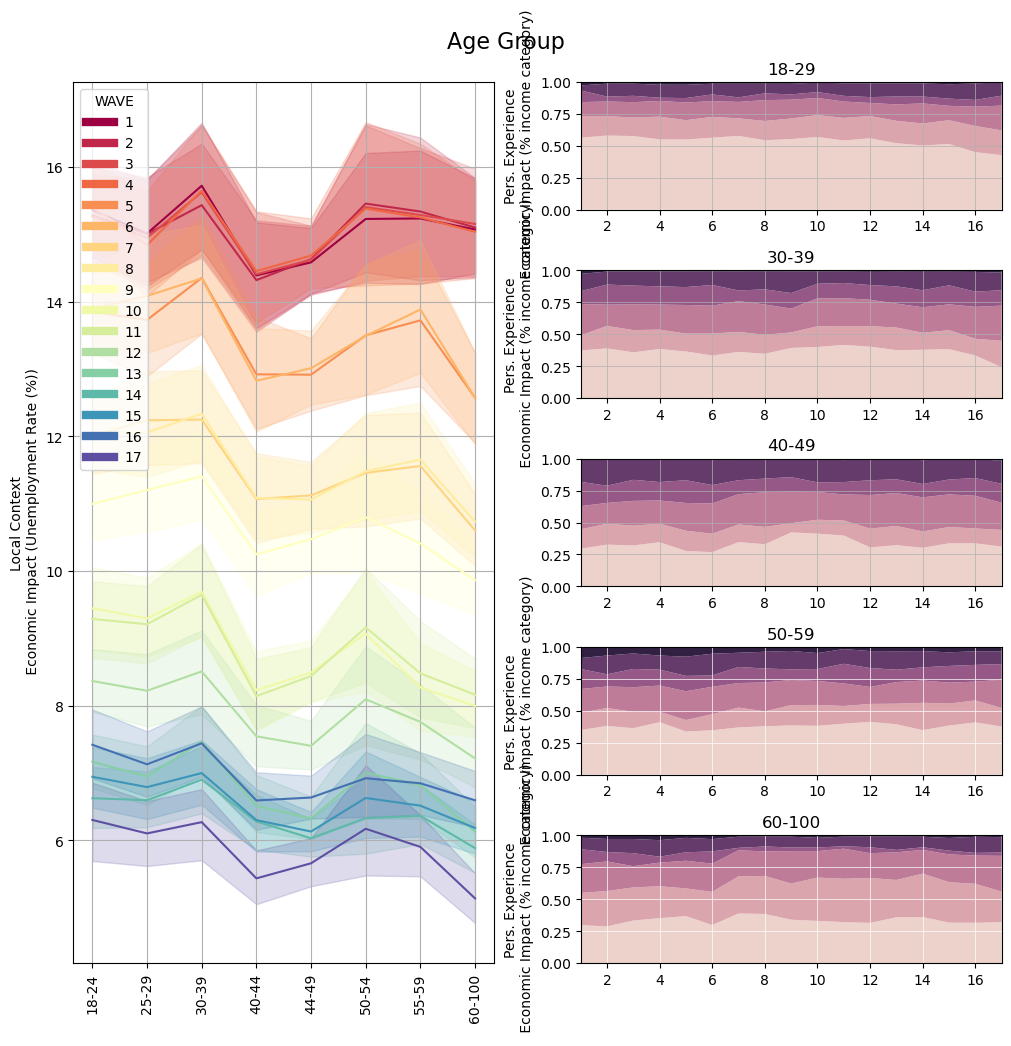

In [54]:
###### Age Group #####

fig, axd = plt.subplot_mosaic([['left', 0],
                              ['left', 1],
                              ['left', 2],
                              ['left', 3],
                               ['left', 4]],
                              figsize=(10,10), layout="constrained")
fig.suptitle('Age Group', fontsize=16)


data['agecat_numeric'] = data['agecats']
data['agecat_numeric'] = data['agecat_numeric'].replace(agecat_numeric_dict)



# local COVID cases
sns.lineplot(data = data,
             y = 'ueRate', x = 'agecat_numeric',
             hue = 'wave',palette = "Spectral",  ax = axd['left'], legend='full')
axd['left'].set_ylabel('Local Context\n Economic Impact (Unemployment Rate (%))')
axd['left'].grid()
leg = axd['left'].legend(title='WAVE',loc='upper left')
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=6)
axd['left'].set_xlabel('')
axd['left'].set_xticks(list(agecat_numeric_dict.values()))
axd['left'].set_xticklabels(['18-24',
                            '25-29',
                            '30-39',
                            '40-44',
                            '44-49',
                            '50-54',
                            '55-59',
                            '60-100'], rotation=90)



data_tmp = data.loc[data.agecats.isin(['age18_24','age25_29']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_18_29 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age30_39']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_30_39 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age40_44','age44_49']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_40_49 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age50_54','age55_59']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_50_59 = income_counts.div(income_counts.sum(axis=1), axis=0) 
data_tmp = data.loc[data.agecats.isin(['age60_100']), ['PROLIFIC_PID','wave', 'weekly_income_self_cat']]
income_counts = data_tmp.groupby(['wave', 'weekly_income_self_cat']).size().unstack(fill_value=0)
income_percentages_60_100 = income_counts.div(income_counts.sum(axis=1), axis=0) 

# countryside
axd[0].stackplot(income_percentages_18_29.index,
                income_percentages_18_29['<$250'], income_percentages_18_29['$250 - $499'],
               income_percentages_18_29['$500 - $999'], income_percentages_18_29['$1000 -$1499'],
               income_percentages_18_29['$1500 - $2999'], income_percentages_18_29['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[0].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[0].set_title('18-29')
axd[0].set_ylim([0,1])
axd[0].set_xlim([1,17])
axd[0].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Independent
axd[1].stackplot(income_percentages_30_39.index,
                income_percentages_30_39['<$250'], income_percentages_30_39['$250 - $499'],
               income_percentages_30_39['$500 - $999'], income_percentages_30_39['$1000 -$1499'],
               income_percentages_30_39['$1500 - $2999'], income_percentages_30_39['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[1].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[1].set_title('30-39')
axd[1].set_ylim([0,1])
axd[1].set_xlim([1,17])
axd[1].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

# Republican
axd[2].stackplot(income_percentages_40_49.index,
                income_percentages_40_49['<$250'], income_percentages_40_49['$250 - $499'],
               income_percentages_40_49['$500 - $999'], income_percentages_40_49['$1000 -$1499'],
               income_percentages_40_49['$1500 - $2999'], income_percentages_40_49['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[2].grid(True, linestyle='-', linewidth=0.5, zorder=2)
axd[2].set_title('40-49')
axd[4].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[2].set_ylim([0,1])
axd[2].set_xlim([1,17])

# Other
axd[3].stackplot(income_percentages_50_59.index,
                income_percentages_50_59['<$250'], income_percentages_50_59['$250 - $499'],
               income_percentages_50_59['$500 - $999'], income_percentages_50_59['$1000 -$1499'],
               income_percentages_50_59['$1500 - $2999'], income_percentages_50_59['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[3].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[3].set_zorder(2)

axd[3].set_title('50-59')
axd[3].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[3].set_ylim([0,1])
axd[3].set_xlim([1,17])



# Other
axd[4].stackplot(income_percentages_60_100.index,
                income_percentages_60_100['<$250'], income_percentages_60_100['$250 - $499'],
               income_percentages_60_100['$500 - $999'], income_percentages_60_100['$1000 -$1499'],
               income_percentages_60_100['$1500 - $2999'], income_percentages_60_100['>$3000'], 
               colors=cat_colors, zorder=1)


# Show grid lines on top by setting a high zorder
axd[4].grid(True, linestyle='-', linewidth=0.5, zorder=2, color = 'white')

# Set a higher zorder for the grid lines to place them on top
axd[4].set_zorder(2)

axd[4].set_title('60-100')
axd[4].set_ylabel('Pers. Experience\n Economic Impact (% income category)')

axd[4].set_ylim([0,1])
axd[4].set_xlim([1,17])

# REGRESSIONS

In [ ]:
cvd_case_coef

In [ ]:
# R2 for mixed effects model
def get_R2(data, dep_var, modelfit):
    # Get the total variance of the model
    total_var = np.var(data[dep_var])

    # Get the variance of the fixed effects
    fixed_var = np.var(modelfit.fittedvalues)
    # Get the variance of the random effects
    random_effects_list = list(modelfit.random_effects.values())
    random_effects = np.empty((len(random_effects_list)))
    for idx, rand_eff in enumerate(random_effects_list):
        random_effects[idx] = rand_eff.values[0]
    random_var = np.mean(random_effects ** 2)

    # Calculate the marginal R-squared
    marginal_r2 = fixed_var / total_var

    # Calculate the conditional R-squared
    conditional_r2 = (fixed_var + random_var) / total_var
    n = len(data)
    k = len(mdf.params)
    adj_r2 = 1 - (1 - marginal_r2) * ((n - 1) / (n - k - 1))

    
    return random_var, marginal_r2, conditional_r2, adj_r2


# country vs city 

In [ ]:
data_countryside_zscore.loc[:,'loc_description_combined'] = 'countryside'
data_middle_city_zscore.loc[:,'loc_description_combined'] = 'city'

combined_data_zscore = pd.concat([data_countryside_zscore, data_middle_city_zscore])

In [ ]:
data_name = ['all subs']


y_vec = ['cases_avg_per_100k','ueRate', 'restriction_sum',
         'mean_social_network_health','weekly_income_self_cat_num','safety_measures']

y_var_loc = []
for loc_type in data_name:
    for y_var in y_vec:
        y_var_loc.append(loc_type+"_"+y_var)

reg_coef = pd.DataFrame()
reg_p_vals = pd.DataFrame()

R_2_adj = pd.DataFrame(index = y_var_loc)

regression_formular = ("cases_avg_per_100k ~ C(polit_party, Treatment('Democrat'))+"
                       "C(race, Treatment('White'))")

data_tmp = data_zscore

data_noNA = data_tmp.dropna(subset='cases_avg_per_100k').copy().reset_index(drop = True)
data_noNA = data_noNA.drop_duplicates()

md = smf.mixedlm(regression_formular, data = data_noNA, groups= "PROLIFIC_PID")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())
#         with open('regression_output/regression_summary_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
#             file.write(str(mdf.summary()))

# collect coefficients
tmp_df_coef = pd.DataFrame(mdf.params)
tmp_df_coef = tmp_df_coef.rename(columns= {0: data_name[idx]+'_'+y})
reg_coef = pd.concat([reg_coef,tmp_df_coef], axis = 1)
# collect p-vals
tmp_df_pvals = pd.DataFrame(mdf.pvalues)
tmp_df_pvals = tmp_df_pvals.rename(columns= {0: data_name[idx]+'_'+y})
reg_p_vals = pd.concat([reg_p_vals,tmp_df_pvals], axis = 1)


random_var, marginal_r2, conditional_r2, adj_r2 = get_R2(data_noNA, 'y', mdf)

print('R-squared adj: ', adj_r2)
R_2_adj.loc[data_name[idx]+'_'+y, 'R_2_adj'] = adj_r2
A = np.identity(len(mdf.params))
A = A[1:,:]
print(mdf.f_test(A))
# with open('regression_output/regression_ftest_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
#     file.write(str(mdf.f_test(A)))
        

In [ ]:
data_name = ['all subs', 'country', 'city']


y_vec = ['cases_avg_per_100k','ueRate', 'restriction_sum',
         'mean_social_network_health','weekly_income_self_cat_num','safety_measures']

y_var_loc = []
for loc_type in data_name:
    for y_var in y_vec:
        y_var_loc.append(loc_type+"_"+y_var)

reg_coef = pd.DataFrame()
reg_p_vals = pd.DataFrame()

R_2_adj = pd.DataFrame(index = y_var_loc)

regression_formular = ("y ~ C(polit_party, Treatment('Independent'))+"
                     "C(race, Treatment('White'))+"
                     "C(sex,  Treatment('Male'))+"
                     "C(education)+age")



for y in y_vec:
    print(y)
 #   for idx,data_tmp in enumerate([data_zscore]):

    for idx,data_tmp in enumerate([data_zscore,data_countryside_zscore, data_middle_city_zscore]):
        print()
        print(data_name[idx])
        data_noNA = data_tmp.dropna(subset=[y]).copy().reset_index(drop = True)
        data_noNA = data_noNA.drop_duplicates()
        data_noNA = data_noNA.rename(columns = {y:'y'})

        md = smf.mixedlm(regression_formular,
                         data = data_noNA, groups= "PROLIFIC_PID")
        mdf = md.fit(method=["lbfgs"])
        print(mdf.summary())
        with open('regression_output/regression_summary_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
            file.write(str(mdf.summary()))

        # collect coefficients
        tmp_df_coef = pd.DataFrame(mdf.params)
        tmp_df_coef = tmp_df_coef.rename(columns= {0: data_name[idx]+'_'+y})
        reg_coef = pd.concat([reg_coef,tmp_df_coef], axis = 1)
        # collect p-vals
        tmp_df_pvals = pd.DataFrame(mdf.pvalues)
        tmp_df_pvals = tmp_df_pvals.rename(columns= {0: data_name[idx]+'_'+y})
        reg_p_vals = pd.concat([reg_p_vals,tmp_df_pvals], axis = 1)


        random_var, marginal_r2, conditional_r2, adj_r2 = get_R2(data_noNA, 'y', mdf)

        print('R-squared adj: ', adj_r2)
        R_2_adj.loc[data_name[idx]+'_'+y, 'R_2_adj'] = adj_r2
        A = np.identity(len(mdf.params))
        A = A[1:,:]
        print(mdf.f_test(A))
        with open('regression_output/regression_ftest_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
            file.write(str(mdf.f_test(A)))
        

In [ ]:
x_var = ['cases_avg_per_100k','ueRate', 'restriction_sum',
         'mean_social_network_health','weekly_income_self_cat_num','safety_measures']


data_name = ['all subs', 'country', 'city']


y_vec = ['cvd_concern', 'cvd_norm_agreement', 'restrict_f1','restrict_f2']

y_var_loc = []
for loc_type in data_name:
    for y_var in y_vec:
        y_var_loc.append(loc_type+"_"+y_var)

reg_coef = pd.DataFrame()
reg_p_vals = pd.DataFrame()

R_2_adj = pd.DataFrame(index = y_var_loc)

# regression_formular = ("y ~ cases_avg_per_100k+restriction_sum+ueRate+"
#                      "mean_social_network_health+safety_measures+weekly_income_self_cat_num+"
#                      "C(polit_party, Treatment('Independent'))+"
#                      "C(race, Treatment('White'))+"
#                      "C(sex,  Treatment('Male'))+"
#                      "C(education)+age")
regression_formular = ("y ~ cases_avg_per_100k+restriction_sum+ueRate+"
                     "mean_social_network_health+safety_measures+weekly_income_self_cat_num")



for y in y_vec:
    print(y)
 #   for idx,data_tmp in enumerate([data_zscore]):

    for idx,data_tmp in enumerate([data_zscore,data_countryside_zscore, data_middle_city_zscore]):
        print()
        print(data_name[idx])
        data_noNA = data_tmp.dropna(subset=[y] + x_var).copy().reset_index(drop = True)
        data_noNA = data_noNA.drop_duplicates()
        data_noNA = data_noNA.rename(columns = {y:'y'})

        md = smf.mixedlm(regression_formular,
                         data = data_noNA, groups= "PROLIFIC_PID")
        mdf = md.fit(method=["lbfgs"])
        print(mdf.summary())
        with open('regression_output/regression_summary_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
            file.write(str(mdf.summary()))

        # collect coefficients
        tmp_df_coef = pd.DataFrame(mdf.params)
        tmp_df_coef = tmp_df_coef.rename(columns= {0: data_name[idx]+'_'+y})
        reg_coef = pd.concat([reg_coef,tmp_df_coef], axis = 1)
        # collect p-vals
        tmp_df_pvals = pd.DataFrame(mdf.pvalues)
        tmp_df_pvals = tmp_df_pvals.rename(columns= {0: data_name[idx]+'_'+y})
        reg_p_vals = pd.concat([reg_p_vals,tmp_df_pvals], axis = 1)


        random_var, marginal_r2, conditional_r2, adj_r2 = get_R2(data_noNA, 'y', mdf)

        print('R-squared adj: ', adj_r2)
        R_2_adj.loc[data_name[idx]+'_'+y, 'R_2_adj'] = adj_r2
        A = np.identity(len(mdf.params))
        A = A[1:,:]
        print(mdf.f_test(A))
        with open('regression_output/regression_ftest_'+ data_name[idx] +'_'+ y +'.txt', 'w') as file:
            file.write(str(mdf.f_test(A)))
        

In [ ]:
reg_coef_copy = reg_coef.copy()
reg_coef_copy.values[np.array(reg_p_vals>0.01)] = np.nan

plot_rows = list(reg_p_vals.index[(reg_p_vals<0.01).sum(axis = 1)>0])
plot_rows.remove('Intercept')
plot_rows.remove('PROLIFIC_PID Var')
for r in ['cases_avg_per_100k', 'restriction_sum',
       'ueRate', 'mean_social_network_health', 'safety_measures']:
    if r not in plot_rows:
        plot_rows.append(r)
    

fig, ax = plt.subplots(1,1)
sns.heatmap(reg_coef_copy.loc[plot_rows, :].round(2), cmap = sns.color_palette("coolwarm", as_cmap=True), 
           vmin = -0.3, vmax = 0.3, ax = ax, linewidth=.5, linecolor = 'black', 
           annot = True, cbar_kws = {'label': 'corr. coef.'})


In [ ]:
reg_coef_copy = reg_coef.copy()
reg_coef_copy.values[np.array(reg_p_vals>0.01)] = np.nan


col_rename_dict = {"C(polit_party, Treatment('Independent'))[T.Other]":'polit. party|Other',
                "C(polit_party, Treatment('Independent'))[T.Republican]":'polit. party|Republican',
                "C(sex, Treatment('Male'))[T.Female]": 'sex at birth|Female',
                "cases_avg_per_100k":'local context - COVID health',
                "restriction_sum":'local context - restriction',
                "ueRate":'local context - economic impact',
                "mean_social_network_health":'personal experience - COVID health',
                "safety_measures":'personal behavior - restriction',
                "weekly_income_self_cat_num":'personal experience - economic impact'}
reg_p_vals = reg_p_vals.T.rename(columns = col_rename_dict)
reg_p_vals = reg_p_vals.T

reg_coef_copy = reg_coef_copy.T.rename(columns = col_rename_dict)
reg_coef_copy = reg_coef_copy.T

plot_rows = list(reg_p_vals.index[(reg_p_vals<0.01).sum(axis = 1)>0])
plot_rows.remove('Intercept')
plot_rows.remove('PROLIFIC_PID Var')


row_order = ["polit. party|Other", 'polit. party|Republican',
             'sex at birth|Female',
            'local context - COVID health', 'personal experience - COVID health',
            'local context - restriction', 'personal behavior - restriction', 
            'local context - economic impact','personal experience - economic impact']
if len(set(row_order) -set(plot_rows))>0:
    print('wrong vars!!!!!!!!!!!')

fig, ax = plt.subplots(1,1)
sns.heatmap(reg_coef_copy.loc[row_order, :].round(2), cmap = sns.color_palette("coolwarm", as_cmap=True), 
           vmin = -0.3, vmax = 0.3, ax = ax, linewidth=.5, linecolor = 'black', 
           annot = True, cbar_kws = {'label': 'corr. coef.'})

# ax.set_yticklabels(['local context - COVID health','personal experience - COVID health',
#                     'local context - restriction','personal behavior - restriction',
#                     'local context - economic impact','personal experience - economic impact'])

ax.set_xticklabels(['all subject - COVID health concern','rural - COVID health concern','urban - COVID health concern',
                    'all subject - COVID norm agreement','rural - COVID norm agreement','urban - COVID norm agreement',
                    'all subject - public restriction attitude','rural - public restriction attitude','urban - public restriction attitude',
                    'all subject - large gatherings restriction attitude','rural - large gatherings restriction attitude','urban - large gatherings restriction attitude'])


# vertical boxes
ax.add_patch(
         patches.Rectangle(
             (0, 0),
             3.0,9.0,
             edgecolor='black',
             fill=False,
             lw=4))

ax.add_patch(
         patches.Rectangle(
             (3, 0),
             3.0,9.0,
             edgecolor='black',
             fill=False,
             lw=4))

ax.add_patch(
         patches.Rectangle(
             (6, 0),
             3.0,9.0,
             edgecolor='black',
             fill=False,
             lw=4))
ax.add_patch(
         patches.Rectangle(
             (9, 0),
             3.0,9.0,
             edgecolor='black',
             fill=False,
             lw=4))


# horizontal boxes
ax.add_patch(
         patches.Rectangle(
             (0,3),
             12,2,
             edgecolor='black',
             fill=False,
             lw=4))

# horizontal boxes
ax.add_patch(
         patches.Rectangle(
             (0,5),
             12,2,
             edgecolor='black',
             fill=False,
             lw=4))

In [ ]:
sns.boxplot(data = data_middle_city_zscore,x = 'weekly_income_self_cat', y = 'cvd_concern', palette = 'Set2')

In [ ]:
data_countryside.columns

In [ ]:
sns.jointplot(data = data_countryside, 
                x = 'restriction_sum', 
                y = 'cvd_concern', kind='hex')

In [ ]:
sns.jointplot(data = data_middle_city_zscore, 
                x = 'mean_social_network_health', 
                y = 'restrict_f1', kind='hex')

In [ ]:
sns.scatterplot(data = data_middle_city, 
                x = 'mean_social_network_health', 
                y = 'restrict_f1')